# Statistical Analysis of TOKIO-ABC Results

This notebook performs various statistical analyses of the summary data generated by each TOKIO-ABC job.  These data are loaded from __a summary csv file__ where each row represents a single job and contains the relevant data extracted from

1. the darshan log
2. the server-side I/O monitoring (Lustre LMT or GPFS GGIOSTAT)
3. optional system-specific monitoring including
    - OST health info (Lustre)
    - Concurrent job count (Slurm)
    - Job radius (Cray XC)
    
This input CSV is generated at NERSC by

1. running `utils/nersc_generate_job_summary.sh` to generate json summary records for each darshan log
2. running `utils/json2csv.py` to convert all jsons into a single csv file

This script is used to identify interesting patterns and correlations across jobs.  For intra-job inspection, use other analysis notebooks such as `analysis/per_ost_deep_dive.ipynb`.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 18})
plt.rcParams['image.cmap'] = 'gray'
import matplotlib.gridspec
import os

In [2]:
import pandas
import numpy as np
import scipy
import scipy.stats as stats
import scipy.interpolate
import json
import datetime
import bisect
import warnings
import textwrap

### black magic necessary for processing Mira log files :(
try:
    import pytz
    _USE_TZ = True
except ImportError:
    _USE_TZ = False

def wrap(text, width=15):
    """wrapper for the wrapper"""
    return '\n'.join(textwrap.wrap(text=text,width=width))

In [3]:
def utc_timestamp_to_YYYYMMDD( timestamp ):
    """
    This is a batty function that allows us to compare the UTC-based
    timestamps from Darshan logs (start_time and end_time) to the
    Chicago-based YYYY-MM-DD dates used to index the mmdf data.
    """
    if _USE_TZ:
        ### we know that these logs are from Chicago
        tz = pytz.timezone("America/Chicago")
        
        ### Darshan log's start time in UTC, so turn it into a datetime with UTC on it
        darshan_time = pytz.utc.localize(datetime.datetime.utcfromtimestamp(timestamp))
        
        ### Then convert this UTC start time into a local start time so
        ### we can compare it to the local mmdf timestamp
        darshan_time_at_argonne = darshan_time.astimezone(tz)
        return darshan_time_at_argonne
    else:
        ### we assume that this script is running on Argonne time; it's the best we can do
        warnings.warn("pytz is not available so mmdf data might be misaligned by a day!")
        return datetime.datetime.fromtimestamp(timestamp)

In [4]:
### Relative path to the repository's root directory
_REPO_BASE_DIR = os.path.join('..', '..')

### Translates cryptic counter names into something suitable for labeling plots
counter_labels = json.load(open(os.path.join(_REPO_BASE_DIR, 'scripts', 'counter_labels.json'), 'r'))

### For consistency, always plot file systems in the same order
_FILE_SYSTEM_ORDER = [ 'scratch1', 'scratch2', 'scratch3', 'mira-fs1' ]

In [5]:
def plot_corr(df,size=20):
    """
    Function plots a graphical correlation matrix for each pair
    of columns in the dataframe.  From
    
    http://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot
    """
    matplotlib.rc('xtick', labelsize=20)
    matplotlib.rc('ytick', labelsize=20)
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr, cmap=plt.get_cmap('seismic'),
                    norm=matplotlib.colors.Normalize(vmin=-1.,vmax=1.) )
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    return corr

## Load data

We've been storing most of the per-job summary data in a single CSV per system.  We

1. Load the CSV directly into a dataframe
2. Drop any rows containing NANs, because if any of the core data is missing (e.g., application name), the whole record is useless.  Hopefully I haven't overlooked anything important in this assumption.
3. Synthesize a few new columns (we call these "metrics" in the paper) to facilitate downstream analysis

In [6]:
### Edison
df_edison = pandas.DataFrame.from_csv(os.path.join(_REPO_BASE_DIR,
                                                   'data',
                                                   'dat',
                                                   'tokio-lustre',
                                                   'edison-abc-stats_2-14_3-23.csv')).dropna()
df_edison['darshan_rw'] = [ 'write' if x == 1 else 'read' for x in df_edison['darshan_write_mode?'] ]
df_edison['darshan_file_mode'] = [ 'shared' if x in ['H5Part','MPIIO'] else 'fpp' for x in df_edison['darshan_api'] ]
df_edison.rename(columns={'lmt_bytes_covered': 'coverage_factor'}, inplace=True)
df_edison['system'] = "edison"
df_edison['iops_coverage_factor'] = -1.0

### Mira
df_mira = pandas.DataFrame.from_csv(os.path.join(_REPO_BASE_DIR,
                                                'data',
                                                'dat',
                                                'tokio-gpfs',
                                                'alcf-abc-stats_2-25_3-19.dat')).dropna()
rename_dict = { '# platform': "system" }
for key in df_mira.keys():
    if key == 'file_sys':
        rename_dict[key] = 'darshan_file_system'
    elif key not in rename_dict and not key.startswith('ggio_'):
        rename_dict[key] = 'darshan_' + key
df_mira.rename(columns=rename_dict, inplace=True)
df_mira['darshan_file_mode'] = [ 'shared' if x in ['H5Part','MPIIO'] else 'fpp' for x in df_mira['darshan_api'] ]
df_mira['coverage_factor'] = df_mira['darshan_total_bytes'] / (df_mira['ggio_bytes_read'] + df_mira['ggio_bytes_written'])
df_mira['iops_coverage_factor'] = (df_mira['darshan_total_rws'] / (df_mira['ggio_read_reqs'] + df_mira['ggio_write_reqs']))

Because I'm lazy, load the `mmdf` data separately and attach it to `df_mira`.

In [7]:
#df_mmdf = pandas.DataFrame.from_csv(os.path.join(_REPO_BASE_DIR,
df_mmdf = pandas.DataFrame.from_csv(os.path.join(_REPO_BASE_DIR,
                                                'data',
                                                'dat',
                                                'tokio-gpfs',
                                                'mira_mmdf_1-25_3-23.csv'),
                                        index_col=['file_system', 'date'])
df_mmdf['free_kib'] = df_mmdf['free_kib_blocks'] + df_mmdf['free_kib_frags']
df_mmdf['free_pct'] = df_mmdf['free_kib'] / df_mmdf['disk_size']

Walk the master dataframe and attach mmdf data.  Note that we're injecting NAs for missing mmdf data because missing mmdf data should not exclude the entire day from our analysis.

In [8]:
### I really hope iterrows behaves deterministically and preserves order...
new_data = {
    'mmdf_avg_fullness_pct': [],
    'mmdf_max_fullness_pct': [],
}

### iterate over each row of the master Mira dataframe
for row in df_mira.itertuples():
    fs_key = row.darshan_file_system
    mmdf_key = utc_timestamp_to_YYYYMMDD( row.darshan_start_time ).strftime("%Y-%m-%d")
    if mmdf_key in df_mmdf.loc[fs_key].index:
        ### only look at today's data
        df = df_mmdf.loc[fs_key].loc[mmdf_key]
        
        data_cols = [ True if x else False for x in df['data?'] ]

        ### calculate a percent fullness - don't bother saving the id of this fullest server though
        new_data['mmdf_max_fullness_pct'].append( 1.0 - df[ data_cols ]['free_pct'].min() )
        new_data['mmdf_avg_fullness_pct'].append( 1.0 - df[ data_cols ]['free_pct'].mean() )
    else:
        warnings.warn("no mmdf data for %s" % datetime.datetime.fromtimestamp(row.darshan_start_time) )
        new_data['mmdf_max_fullness_pct'].append( np.nan )
        new_data['mmdf_avg_fullness_pct'].append( np.nan )

for new_col_name, new_col_data in new_data.iteritems():
    df_mira[new_col_name] = new_col_data

/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: no mmdf data for 2017-02-24 20:17:41
/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: no mmdf data for 2017-02-24 20:19:39
/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: no mmdf data for 2017-02-24 20:21:34
/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: no mmdf data for 2017-02-24 20:24:33
/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: no mmdf data for 2017-02-24 20:29:40
/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: no mmdf data for 2017-02-24 20:30:58
/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: no mmdf data for 2017-02-26 02:04:26
/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: no mmdf data for 2017-02-26 0

Now merge both DataFrames so we can look at all the data if we really want to.  This DataFrame will have a bunch of NANs for data that is only applicable to Mira or Edison.

In [9]:
df_concat = pandas.concat( (df_mira, df_edison) )

## Filter Data

Two notable filters are applied:

1. All jobs where the bytes coverage factor and ops coverage factor are greater than 1.2 are discarded because they reflect severely misaligned or gappy data.

2. Mira job 1039807 is excluded because ggiostat returned highly abnormal results starting that day.  See e-mail from Shane and Phil on March 23 about this.

3. All Edison jobs from March 12 were discarded because LMT broke as a result of daylight saving time rolling over.  This filter was applied _before_ the input CSV files loaded above were generated, so it does not need to be applied here.

In [10]:
for df in df_mira, df_edison, df_concat:
    df.drop(df.index[df['coverage_factor'] > 1.2], inplace=True)
    df.drop(df.index[df['iops_coverage_factor'] > 1.2], inplace=True)
    
    df.drop(df.index[(df['system'] == 'mira') & (df['darshan_jobid'] == 1039807)], inplace=True)

## Normalize Performance
Different file systems, benchmarks, and read/write modes are capable of different peak bandwidths.  As such, we want to normalize the absolute performance (`summarize_key`) by something.  For convenience we calculate the denominator for normalization a couple of different ways (e.g., the mean, median, and max measurement).  We also limit normalization to unique combinations of variables specified by `normalization_group` below.

Calculate the normalization factors (the denominators), then apply that factor to all of the data in the DataFrame.  These normalized data will be saved as new columns in the DataFrame.

In [12]:
### The actual variable we want to normalize
summarize_key = 'darshan_agg_perf_by_slowest'

for df in df_edison, df_mira, df_concat:
    ### Specify which keys we want to group together before normalizing
    normalization_group = df.groupby(['darshan_app', 'darshan_file_system', 'darshan_file_mode', 'darshan_rw'])

    ### Dict to store the denominators for normalization
    normalization_data = {
        'mean':   normalization_group.darshan_agg_perf_by_slowest.mean(),
        'median': normalization_group.darshan_agg_perf_by_slowest.median(),
        'max':    normalization_group.darshan_agg_perf_by_slowest.max(),
    }

    ### Normalize every row in the DataFrame by all of our denominators
    new_cols = {}
    for func in normalization_data.keys():
        new_col_key = 'darshan_normalized_perf_by_%s' % func
        new_cols[new_col_key] = []
        for index, row in df.iterrows():
            new_cols[new_col_key].append(
                row[summarize_key] / normalization_data[func]
                                                       [row['darshan_app']]
                                                       [row['darshan_file_system']]
                                                       [row['darshan_file_mode']]
                                                       [row['darshan_rw']]
            )

    ### Also just do per-file system
    normalization_group = df.groupby('darshan_file_system')
    normalization_data = {
        'mean':   normalization_group.darshan_agg_perf_by_slowest.mean(),
        'median': normalization_group.darshan_agg_perf_by_slowest.median(),
        'max':    normalization_group.darshan_agg_perf_by_slowest.max(),
    }
    for func in normalization_data.keys():
        new_col_key = 'darshan_normalized_perf_by_fs_%s' % func
        new_cols[new_col_key] = []
        for index, row in df.iterrows():
            new_cols[new_col_key].append(
                row[summarize_key] / normalization_data[func][row['darshan_file_system']])

    ### Take our normalized data and add them as new columns
    for new_col, new_col_data in new_cols.iteritems():
        df[new_col] = new_col_data

## Multivariate Correlation Analysis
`performance_key` is the variable we wish to use to represent performance.  It is typically

- `darshan_agg_perf_by_slowest`, which is the absolute performance measured by each benchmark run
- `darshan_normalized_perf_by_max`, which is normalized by the maximum observed performance
- `darshan_normalized_perf_by_mean`, which is normalized by the mean observed performance

In [13]:
performance_key = 'darshan_normalized_perf_by_max'

### Pearson Correlation Analysis
Pearson analysis assumes that each variable is normally distributed.  It is easier to understand, but it is not technically correct for variables that are _not_ normally distributed, which include performance.  The Spearman coefficient would be better.

At any rate, this correlation matrix is not of interest to this paper so don't bother generating it here.

In [14]:
### make a pretty plot to flag highlights
if False:
    corr_edison = plot_corr(df_edison[
        (df_edison['darshan_file_system'] == 'scratch1') 
        | (df_edison['darshan_file_system'] == 'scratch2') 
        | (df_edison['darshan_file_system'] == 'scratch3')
    ], 10)
    corr_mira = plot_corr(df[df['darshan_file_system'] == 'mira-fs1'], 10)

### Numerical Correlation Analysis
Now we repeat this correlation analysis, but this time use `scipy.stats` instead of `pandas` so that we can calculate p-values associated with each correlation.  The ultimate artifact of this process is a table of interesting correlations, their correlation coefficients, and color coding to indicate the confidence of those coefficients based on p-values.

In [81]:
ignore_cols = [
    'lmt_tot_zeros',
    'lmt_frac_zeros',
    'lmt_frac_missing',
    'ost_avg_kib',
    'ost_min_pct',
    'ost_min_kib',
    'ost_max_kib',
    'ost_count',
#   'ost_bad_ost_count',
    'ost_bad_ost_pct',
    'ost_failures_lead_secs',
    'ost_fullness_lead_secs',
    'lmt_tot_missing',
    'ost_avg_bad_ost_per_oss',
    'ost_avg_bad_overload_factor',
    'ost_bad_oss_count',
    'ost_min_id',
    'ost_max_id',
    'job_min_radius',
    'job_avg_radius',
### second pass
    'lmt_ops_getattrs',
    'lmt_ops_getxattrs',
    'lmt_ops_rmdirs',
    'lmt_ops_unlinks',
    'lmt_ops_renames',
    'lmt_ops_setattrs',
    'lmt_ops_mkdirs',
    'ggio_inoded_updates',
### third pass
    "lmt_mds_ave",
    "lmt_oss_ave",
]

### if one key has the same logical meaning as another, this will remap those
### keys so they line up in the DataFrame
equivalent_keys = {
    'ggio_closes':     'lmt_ops_closes',
    'ggio_opens': 'lmt_ops_opens',
    'ggio_bytes_read': 'lmt_tot_bytes_read',
    'ggio_bytes_written': 'lmt_tot_bytes_write',
    'mmdf_max_fullness_pct': 'ost_max_pct',
    'mmdf_avg_fullness_pct': 'ost_avg_pct',
}

### Specific names for the table
counter_labels_table = {
    'coverage_factor': "Coverage Factor (Bandwidth)",
    "ost_avg_pct": "Avg LUN Fullness",
    "ost_max_pct": "Fullness on Fullest LUN",
    "lmt_oss_max": "Max CPU Load, Data Server",
    "ost_bad_pct": "% Servers Failed Over",
    "ost_bad_ost_count": "Failed-over Servers",
    "lmt_ops_closes": "close(2) Calls",
    "lmt_ops_opens": "open(2) Calls",
    "lmt_tot_bytes_write": "Bytes Written",
    "lmt_tot_bytes_read": "Bytes Read",
    "lmt_mds_max": "Max CPU Load, Metadata Server",
    "lmt_mds_ave": "Avg CPU Load, Metadata Server",
    "job_concurrent_jobs": "# Concurrent Jobs",
    "lmt_oss_ave": "Avg CPU Load, Data Server",
    "job_max_radius": "Job Diameter",
    "iops_coverage_factor": "Coverage Factor (IOPS)",
    "ggio_write_reqs": "Write Ops",
    "ggio_read_reqs": "Read Ops",
}

### Order in which table is to be printed
print_order = [
    'coverage_factor',
    "iops_coverage_factor",
    "lmt_ops_closes",
    "lmt_ops_opens",
    "lmt_tot_bytes_write",
    "lmt_tot_bytes_read",
    "ggio_write_reqs",
    "ggio_read_reqs",
    "ost_max_pct",
    "ost_avg_pct",
    "lmt_mds_max",
    "lmt_oss_max",
    "ost_bad_ost_count",
    "job_concurrent_jobs",
    "job_max_radius",
]

In [91]:
def correlation_calculation(df,
                            analysis_func=stats.pearsonr,
                            only_print_key=performance_key,
                            ignore_cols=[],
                            max_pval=1.01):
    """
    Calculate the Pearson correlation coefficient and the associated
    p-value for various counter pairs.  If only_print_key is None,
    every possible combination of columns in df is attempted; otherwise,
    the column identified by only_print_key is compared against all other
    columns.
    """
    num_cols = len(df.keys())
    results = []
    
    if only_print_key is None:
        i_range = range(num_cols - 1)
    else:
        i_range = [ list(df.columns).index(only_print_key) ]

    for i in i_range:
        i_col = df.columns[i]
        if only_print_key is None:
            j_range = range(i, num_cols)
        else:
            j_range = range(len(df.columns))
            j_range.remove(i_range[0]) # degenerate case
        for j in j_range:
            j_col = df.columns[j]
            try:
                ### The Scipy stats package barfs if x or y contain any
                ### NANs, but we don't want to drop all records that
                ### contain any nans.  So, we wait until the very last
                ### minute to drop only those columns that contain nans
                ### that we would otherwise try to correlate.
                df_corr = df[[i_col, j_col]].dropna()
                coeff, pval = analysis_func(df_corr[i_col],
                                            df_corr[j_col])
            except TypeError: # non-numeric column
                continue
            results.append((i_col,
                            j_col,
                            coeff,
                            pval))

    ### now start dropping correlations that we don't want/need
    sorted_results = sorted(results, key=lambda x: x[3])
    ret_results = []
    for col_name1, col_name2, coeff, pval in sorted_results:
        ### don't print trivial relationships
        if pval == 0 or pval == 1:
            continue
        ### don't print relationships with very high p-values
        if pval > max_pval:
            continue
        ### don't correlate data from the same source since much of it is degenerate
        if col_name1.split('_',1)[0] == col_name2.split('_',1)[0]:
            continue
        ### don't print anything except for the key of interest (if provided)
        if only_print_key is not None \
        and col_name1 != only_print_key \
        and col_name2 != only_print_key:
            continue
        if col_name1 in ignore_cols or col_name2 in ignore_cols:
            continue
#       print "%10.4f %10.4g %30s : %-15s" % (coeff, pval, col_name1, col_name2)
        
        ### sort the output key orders
        if col_name1 == only_print_key:
            ret_results.append([col_name1,col_name2,coeff,pval])
        elif col_name2 == only_print_key:
            ret_results.append([col_name2,col_name1,coeff,pval])
        else:
            if col_name2 > col_name1:
                ret_results.append([col_name1,col_name2,coeff,pval])
            else:
                ret_results.append([col_name2,col_name1,coeff,pval])
    return ret_results

In [94]:
def correlation_dict_to_dataframe(correlations):
    ### to_df: dict we will use to store arrays -> pd.Series
    to_df = {}

    ### common_key: needed to figure out which key is the independent variable
    common_key = None

    ### list that will become dataframe index
    key_index = []

    ### loop over all systems, all correlations, all pairs of variables
    for system, records in correlations.iteritems():
        for row in records:
            ### try to figure out which of the two keys is not repeated
            if common_key is None:
                common_key = row[0]
            if row[0] != common_key:
                common_key = row[1]
                unique_key = row[0]
            else:
                unique_key = row[1]

            ### convert compatible key names from ggio_ to lmt_
            if unique_key in equivalent_keys:
                unique_key = equivalent_keys[unique_key]

            ### build up a list of keys that will be our Index
            if unique_key not in key_index:
                key_index.append(unique_key)

            ### fill out the dict 
            counterkey = "counter_%s" % system
            corrkey = 'correlation_%s' % system
            pvalkey = 'p-value_%s' % system
            if counterkey not in to_df: to_df[counterkey] = []
            if corrkey not in to_df: to_df[corrkey] = []
            if pvalkey not in to_df: to_df[pvalkey] = []
            to_df[counterkey].append(unique_key)
            to_df[corrkey].append(row[2])
            to_df[pvalkey].append(row[3])

    ### Make an empty but indexed data frame
    df = pandas.DataFrame(index=key_index)
    for system in correlations.keys():
        counterkey = "counter_%s" % system
        corrkey = 'correlation_%s' % system
        pvalkey = 'p-value_%s' % system

        df[corrkey] = pandas.Series(to_df[corrkey], index=to_df[counterkey])
        df[pvalkey] = pandas.Series(to_df[pvalkey], index=to_df[counterkey])

    return df

In [95]:
### Calculate unconstrainted correlation table just for our edification
### Calculate correlations between performance and everything else
correlations = {}

correlations['edison'] = correlation_calculation(df_edison)
correlations['mira'] = correlation_calculation(df_mira)

correlation_dict_to_dataframe( correlations )

,correlation_edison,p-value_edison,correlation_mira,p-value_mira
lmt_tot_zeros,-0.497220,1.835391e-61,NaN,NaN
coverage_factor,0.437681,1.785791e-46,0.375883,0.000426
lmt_frac_zeros,-0.395295,1.752172e-37,NaN,NaN
ost_avg_kib,-0.384375,2.275931e-35,NaN,NaN
ost_avg_pct,-0.384375,2.275931e-35,0.061464,0.621231
ost_min_pct,-0.381876,6.758325e-35,NaN,NaN
ost_min_kib,-0.381876,6.758325e-35,NaN,NaN
ost_max_kib,-0.366718,4.070626e-32,NaN,NaN
ost_max_pct,-0.366718,4.070626e-32,0.061193,0.622774
ost_count,-0.308408,9.872731e-23,NaN,NaN


In [96]:
### Calculate correlations between a subset of interesting measurements
### so we can generate the correlation table
correlations = {}

correlations['edison'] = correlation_calculation(df_edison, ignore_cols=ignore_cols)
correlations['mira'] = correlation_calculation(df_mira, ignore_cols=ignore_cols)

df = correlation_dict_to_dataframe( correlations )
df

,correlation_edison,p-value_edison,correlation_mira,p-value_mira
coverage_factor,0.437681,1.785791e-46,0.375883,0.000426
ost_avg_pct,-0.384375,2.275931e-35,0.061464,0.621231
ost_max_pct,-0.366718,4.070626e-32,0.061193,0.622774
lmt_oss_max,-0.237031,8.384589e-14,NaN,NaN
ost_bad_pct,0.175406,4.082602e-08,NaN,NaN
ost_bad_ost_count,0.175406,4.082602e-08,NaN,NaN
lmt_ops_closes,-0.102514,1.420340e-03,-0.280064,0.009874
lmt_ops_opens,-0.101647,1.559697e-03,-0.277375,0.010636
lmt_tot_bytes_write,-0.089701,5.271314e-03,-0.038061,0.731050
lmt_mds_max,-0.082880,9.964685e-03,NaN,NaN


                   ost_max_pct pval=    0.6228; setting color to red
                lmt_ops_closes pval=    0.0014; setting color to blue
          iops_coverage_factor pval=    0.0000; setting color to blue
           job_concurrent_jobs pval=    0.1270; setting color to red
           lmt_tot_bytes_write pval=    0.7310; setting color to red
                 lmt_ops_opens pval=    0.0016; setting color to blue
                   ost_max_pct pval=    0.0000; setting color to blue
                ggio_read_reqs pval=    0.0004; setting color to blue
                job_max_radius pval=    0.7728; setting color to red
           lmt_tot_bytes_write pval=    0.0053; setting color to blue
                   ost_avg_pct pval=    0.0000; setting color to blue
                 lmt_ops_opens pval=    0.0106; setting color to green
               coverage_factor pval=    0.0004; setting color to blue
               ggio_write_reqs pval=    0.0022; setting color to blue
            lmt_tot_byt

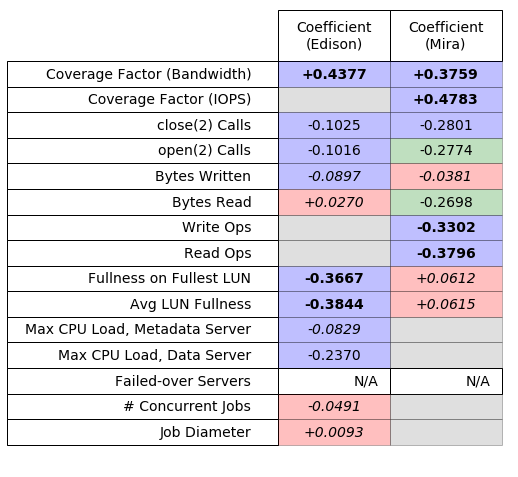

In [89]:
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(111)

column_headers = {
    "correlation_edison": "Coefficient\n(Edison)",
    "correlation_mira": "Coefficient\n(Mira)",
    "p-value_edison": "P-value (Edison)",
    "p-value_mira": "P-value (Mira)",
}

coefficient_keys = [x for x in df.columns if x.startswith('correlation_')]

### the index is column -1
table = pandas.tools.plotting.table(ax,
                            df[coefficient_keys].reindex(print_order),
                            loc='upper right',
                            colWidths=[0.8,0.8,3.8],
                            bbox=[0, 0, 1, 1])
table.set_fontsize(14)
ax.axis('tight')
ax.axis('off')

### Rewrite the contents of the table that Pandas gave us
cells_dict = table.get_celld()
remap_values = {}
for cell_pos, cell_obj in cells_dict.iteritems():
    i, j = cell_pos
    value = cell_obj.get_text().get_text()
    height_scale = 1.0
    if i == 0:    # column headers
        remap_values[cell_pos] = column_headers.get(value, value)
        height_scale = 2.0
    elif j == -1: # index cell
        remap_values[cell_pos] = counter_labels_table.get(value, value)
        cell_obj._loc = 'right'
    else:         # coefficient cell
        index = cells_dict[(i,-1)].get_text().get_text()
        column = cells_dict[(0,j)].get_text().get_text()
        
        ### need a special handler for ost_bad_ost_count because Pearson
        ### will correlate against it even though it is invariant :(
        ### TODO: fix it so that we don't try to correlate against constants
        if index == 'ost_bad_ost_count':
            remap_values[cell_pos] = "N/A"
            cell_obj.set_color('white')
        elif value == "nan":
            cell_obj.set_color('grey')
            remap_values[cell_pos] = ""
            cell_obj.set_alpha(0.25)
            cell_obj._loc = 'center'
        else:
            coeff = float(value)
            pval = df.loc[index][column.replace('correlation','p-value')]

            ### make moderate correlations **bold**
            if abs(coeff) >= 0.30:
                cell_obj.get_text().set_fontweight('bold')
            elif abs(coeff) < 0.10:
                cell_obj.get_text().set_fontstyle('italic')

            ### color code cells based on p-value
            if pval < 0.01:
                set_color = 'blue'
            elif pval < 0.05:
                set_color = 'green'
            else:
                set_color = 'red'
            
            ### for debugging, since the resulting figure doesn't contain any p-values
            print "%30s pval=%10.4f; setting color to %s" % (
                index, pval, set_color
            )
            cell_obj.set_color(set_color)
            cell_obj.set_alpha(0.25)
            cell_obj._loc = 'center'
            remap_values[cell_pos] = "%+.4f" % coeff
    cell_obj.set_height(height_scale * cell_obj.get_height())
    cell_obj.set_edgecolor('black')

### Actually rewrite the cells now
for cell_pos, new_value in remap_values.iteritems():
    cells_dict[cell_pos].get_text().set_text(new_value)
    
output_file = "correlation_table.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

### Scatter Plots
To visualize these correlations, we define pairs of counters to plot against each other:

In [97]:
scatterplots = [ 
    (performance_key, 'coverage_factor'),
    (performance_key, 'lmt_oss_max'),
    (performance_key, 'job_concurrent_jobs'),
    (performance_key, 'ost_avg_pct'),
    (performance_key, 'ost_max_kib'),
    (performance_key, 'coverage_factor'),
    (performance_key, 'ggio_write_reqs'),
    (performance_key, 'ggio_write_reqs'),
]

...and then plot them:

Saved scatter_darshan_normalized_perf_by_max_vs_coverage_factor.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_lmt_oss_max.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_job_concurrent_jobs.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_ost_avg_pct.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_coverage_factor.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_ggio_write_reqs.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_ggio_write_reqs.pdf


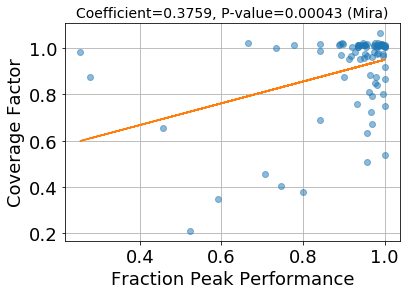

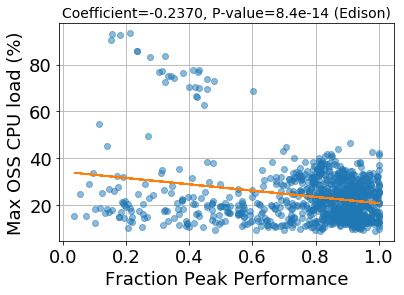

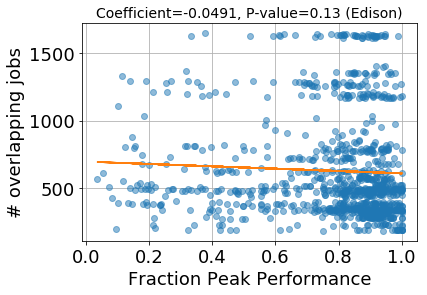

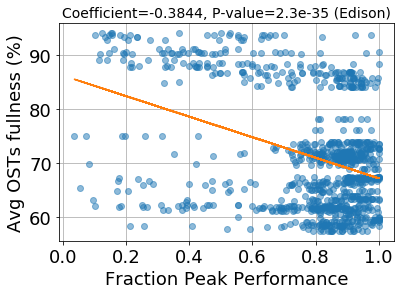

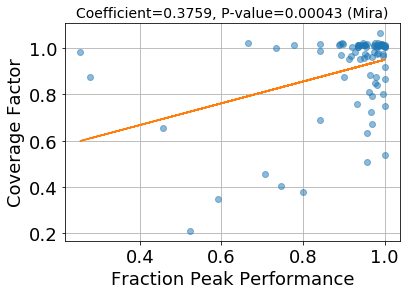

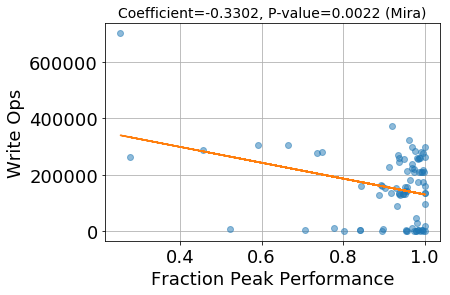

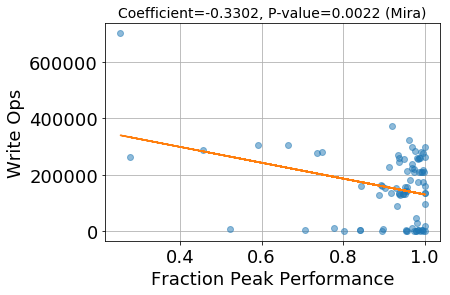

In [98]:
blacklist = set([
    'ost_max_id', 'ost_min_id', 'lmt_tot_zeros',
    'ost_failures_lead_secs', 'ost_fullness_lead_secs',
    'ost_max_kib', 'ost_avg_kib', 'ost_min_kib', 
    'lmt_tot_missing'
])
# for scatterplot in correlations_edison + correlations_mira:
for scatterplot in scatterplots:
    x_key = scatterplot[0]
    y_key = scatterplot[1]
    if x_key in blacklist or y_key in blacklist:
        continue
    if y_key in df_mira :
        df_plot = df_mira
        system = "Mira"
    elif y_key in df_edison:
        df_plot = df_edison
        system = "Edison"
    else:
        warnings.warn("Cannot find key %s in any data frames" % y_key)
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    
    x = df_plot[x_key].values
    x_label = counter_labels.get(x_key, x_key)
    y = df_plot[y_key].values
    y_label = counter_labels.get(y_key, y_key)
#   ax.hexbin(x, y, gridsize=25, cmap='PuRd')
    ax.plot(x, y, 'o', alpha=0.5)

    ### attempt a linear fit to generate a visual aid
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x+b, "-")
    
    ### add window dressing to plots
#   fig.suptitle('Correlation between %s and %s' 
#                 % (x_label.split('(',1)[0].strip(),
#                    y_label.split('(',1)[0].strip()))
    ax.set_title("Coefficient=%.4f, P-value=%.2g (%s)" 
                    % sum((stats.pearsonr(x, y), (system,)), ()), fontsize=14 )
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.grid(True)
    output_file = "scatter_%s_vs_%s.pdf" % (x_key, y_key)
    fig.savefig(output_file, bbox_inches="tight")
    print "Saved %s" % output_file

Mira also has both server-side and client side IOPS.  Let's look at those specifically:

Write Ops -0.330181646216 0.00215977302826
Read Ops -0.379631069251 0.000368665826371
Saved scatter_mira_ops.pdf


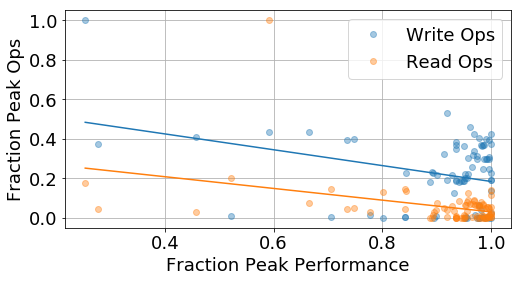

In [21]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

df = df_mira.sort_values(performance_key).copy()

for x_key, y_key in [(performance_key, 'ggio_write_reqs'),
                    (performance_key, 'ggio_read_reqs')]:
    x = df[x_key].values
    y = df[y_key].values / df[y_key].max()
    corr = stats.pearsonr(x, y)
    print counter_labels.get(y_key, y_key), corr[0], corr[1]
    points = ax.plot(x, y,
                     'o',
                     alpha=0.4,
                     markersize=6.0,
                     label="%s" % (counter_labels.get(y_key, y_key))
                    )
        
    ### attempt a linear fit to generate a visual aid
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x+b,
            "-",
           color=points[0].get_color())
    
ax.set_xlabel(counter_labels.get(x_key, x_key))
ax.set_ylabel("Fraction Peak Ops")
ax.legend()
plt.grid(True)
output_file = "scatter_mira_ops.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

iops_coverage_factor 0.420121233262 6.93435261987e-05
Saved scatter_mira_ops.pdf


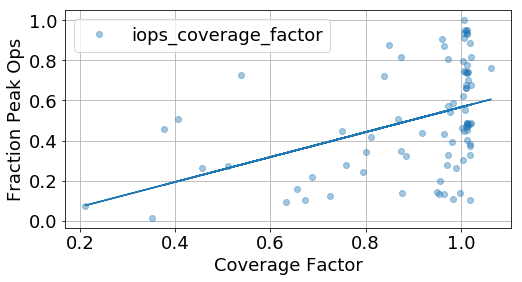

In [22]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

df = df_mira.sort_values(performance_key).copy()

for x_key, y_key in [('coverage_factor', 'iops_coverage_factor')]:
    x = df[x_key].values
    y = df[y_key].values / df[y_key].max()
    corr = stats.pearsonr(x, y)
    print counter_labels.get(y_key, y_key), corr[0], corr[1]
    points = ax.plot(x, y,
                     'o',
                     alpha=0.4,
                     markersize=6.0,
                     label="%s" % (counter_labels.get(y_key, y_key))
                    )
        
    ### attempt a linear fit to generate a visual aid
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x+b,
            "-",
           color=points[0].get_color())
    
ax.set_xlabel(counter_labels.get(x_key, x_key))
ax.set_ylabel("Fraction Peak Ops")
ax.legend()
plt.grid(True)
output_file = "scatter_mira_ops.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

Plot the correlation between coverage factor and performance for each file system separately

Saved scatter_perf-vs-cf_scratch1.pdf
Saved scatter_perf-vs-cf_scratch1.pdf
Saved scatter_perf-vs-cf_scratch1.csv
Saved scatter_perf-vs-cf_scratch2.pdf
Saved scatter_perf-vs-cf_scratch2.pdf
Saved scatter_perf-vs-cf_scratch2.csv
Saved scatter_perf-vs-cf_scratch3.pdf
Saved scatter_perf-vs-cf_scratch3.pdf
Saved scatter_perf-vs-cf_scratch3.csv
Saved scatter_perf-vs-cf_mira-fs1.pdf
Saved scatter_perf-vs-cf_mira-fs1.pdf
Saved scatter_perf-vs-cf_mira-fs1.csv


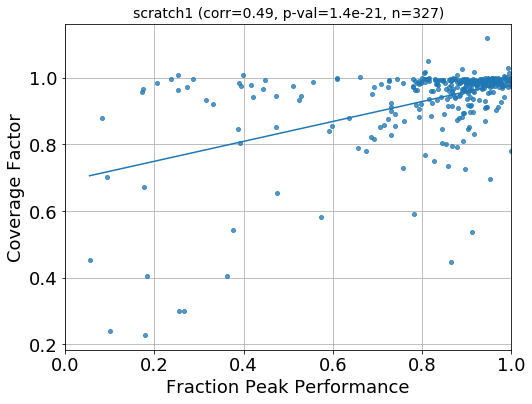

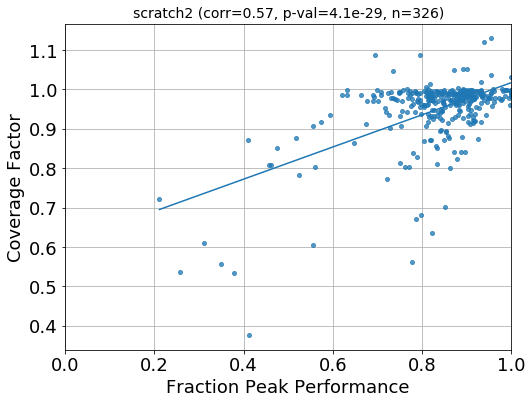

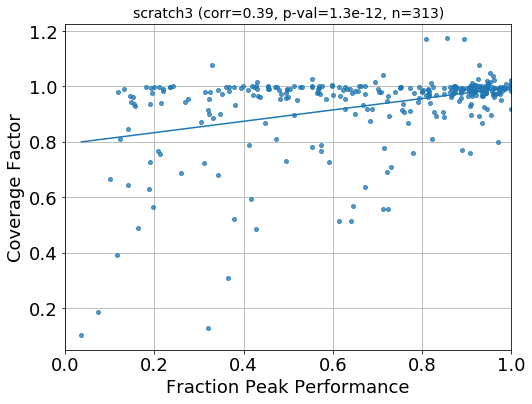

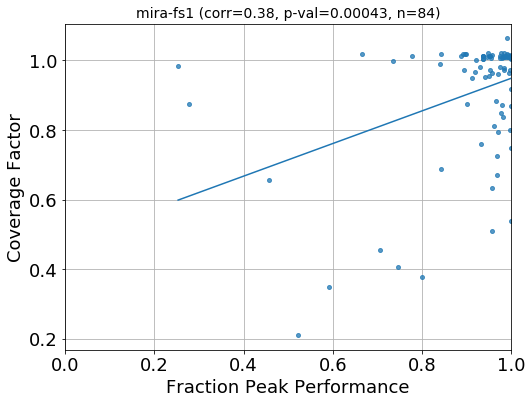

In [23]:
# for scatterplot in correlations_mira:
for idx, fs in enumerate(_FILE_SYSTEM_ORDER):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    x_key = performance_key
    y_key = 'coverage_factor'
    if fs.startswith('mira') :
        df_plot = df_mira.sort_values(performance_key)
        system = "Mira"
    elif fs.startswith('scratch'):
        df_plot = df_edison.sort_values(performance_key)
        system = "Edison"
    else:
        warnings.warn("Cannot find key %s in any data frames" % y_key)
    df_plot = df_plot[df_plot['darshan_file_system'] == fs]
    
    x = df_plot[x_key].values
    y = df_plot[y_key].values
    corr = stats.pearsonr(x, y)
    label = "%s (corr=%.2f, p-val=%4.2g, n=%d)" % (fs, corr[0], corr[1], len(df_plot))
    points = ax.plot(x, y,
                     'o', 
                     alpha=0.75,
                     markersize=4.0)

    ### attempt a linear fit to generate a visual aid
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x+b,
            "-",
           color=points[0].get_color())
    
    ### make the plot pretty
    ax.set_xlim([0.0,2.0 if 'mean' in x_key else 1.0])
    ax.set_ylabel("Coverage Factor")
    ax.set_xlabel(counter_labels[performance_key])
    ax.set_title(label, fontsize=14)
    plt.grid(True)
    output_file = "scatter_perf-vs-cf_%s.pdf" % fs
    fig.savefig(output_file, bbox_inches="tight")
    print "Saved %s" % output_file
    fig.savefig(output_file.replace('pdf', 'png'), bbox_inches="tight")
    print "Saved %s" % output_file
    df_save = pandas.DataFrame({"Performance Relative to Mean": x,
                                "Coverage Factor": y}).to_csv(output_file.replace('pdf', 'csv'))
    print "Saved", output_file.replace('pdf', 'csv')

## Distribution of each benchmark type

Following cell defines which variable we wish to aggregate into boxplots and a few plotting parameters that depend on our choice of variable.

In [24]:
boxplot_settings = {
    'fontsize': 15,
    'darshan_normalized_perf_by_fs_max': {
        'output_file': "perf-boxplots-per-fs.pdf",
        'ylabel': "Fraction of Peak\nFile System Performance",
        'title_pos': [ 
            {'x': 0.97, 'y': 0.80, 'horizontalalignment': 'right', 'fontsize': 14},
            {'x': 0.04, 'y': 0.02, 'horizontalalignment': 'left', 'fontsize': 14}]
    },
    'darshan_normalized_perf_by_max': {
        'output_file': "perf-boxplots.pdf",
        'ylabel': "Fraction of Peak\nPer-Benchmark Performance",
        'title_pos': [ 
            {'x': 0.04, 'y': 0.02, 'horizontalalignment': 'left', 'fontsize': 14},
            {'x': 0.04, 'y': 0.02, 'horizontalalignment': 'left', 'fontsize': 14}]
    },
}

We plot two sets of boxplots based on the normalization denominator:

1. normalized by the maximum without any grouping (other than file system)
2. normalized by the maximum of each unique combination of app-read/write-filemode

The idea is to show that

1. performance variation varies across different file systems and different applications
2. even within an application, the magnitude of performance variation varies with file system

Saved perf-boxplots.pdf
Saved perf-boxplots-per-fs.pdf


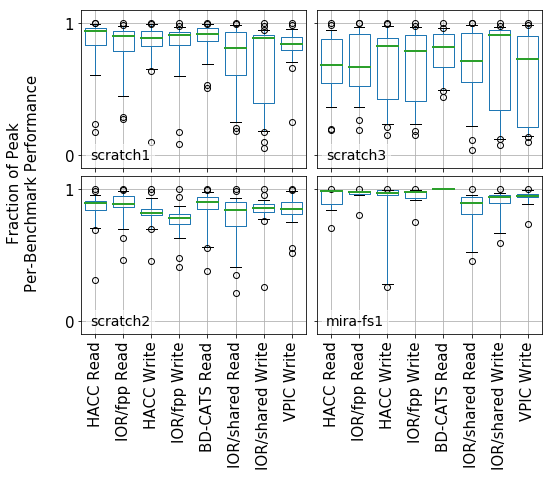

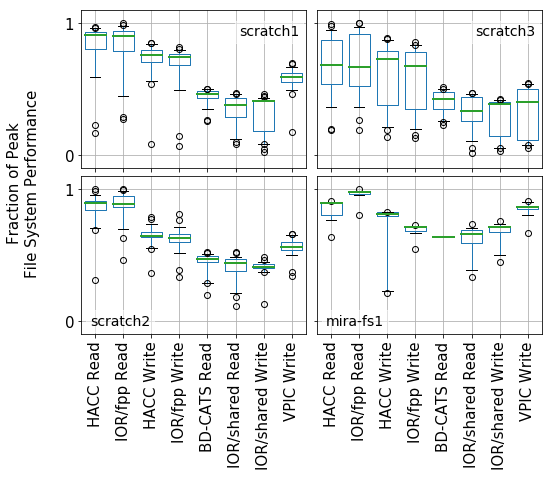

In [25]:
for plot_variable in performance_key, performance_key.replace('_by_', '_by_fs_'):
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
    fig.set_size_inches(8,6)
    boxplot_group_by = [ 'darshan_file_mode', 'darshan_rw', 'darshan_app' ]
    for idx, fs in enumerate(_FILE_SYSTEM_ORDER):
        icol = idx / 2
        irow = idx % 2
        ax = axes[irow, icol]
        df_concat.loc[df_concat["darshan_file_system"] == fs]\
        .boxplot(
            column=[plot_variable],
            by=boxplot_group_by,
            ax=axes[irow, icol],
            medianprops={'linewidth':2 },
            widths=0.75,
            whis=[5,95])

        settings = boxplot_settings[plot_variable]['title_pos'][irow]
        title = ax.set_title(fs, **(settings))
        title.set_bbox({'color': 'white', 'alpha': 0.5})
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.xaxis.grid(True)

        ### relabel the x axis labels
        new_labels = []
        for axis_label in ax.get_xticklabels():
            current_label = axis_label.get_text()
            axis_label.set_rotation(90)
            if "IOR" in current_label:
                if "shared" in current_label:
                    new_label = "IOR/shared"
                else:
                    new_label = "IOR/fpp"
            elif 'BD-CATS' in current_label:
                new_label = "BD-CATS"
            else:
                new_label = current_label.split(',')[2].strip(')').strip().split('-')[0]
            if 'write' in current_label:
                new_label += " Write"
            else:
                new_label += " Read"
            new_labels.append(new_label)

        ### set x tick labels for only the bottom row
        if irow == 0:
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels(new_labels,
                               fontsize=boxplot_settings['fontsize'])

        ax.yaxis.set_ticks([0.0, 1.0])
        ax.set_ylim([-0.1, 1.1])
        for ytick in ax.yaxis.get_major_ticks():
            ytick.label.set_fontsize(boxplot_settings['fontsize'])

        
    fig.suptitle("")
    # fig.text(0.5, -0.4, 'common X', ha='center')
    fig.text(0.0, 0.5,
             boxplot_settings[plot_variable]['ylabel'],
             verticalalignment='center',
             horizontalalignment='center',
             rotation='vertical',
             fontsize=boxplot_settings['fontsize'])
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    output_file = boxplot_settings[plot_variable]['output_file']
    fig.savefig(output_file, bbox_inches="tight")
    print "Saved %s" % output_file

Also plot a more general overview of performance across each file system.

Saved perf-boxplots-fs.pdf


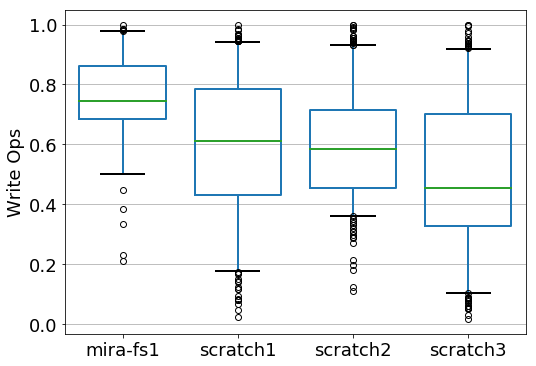

In [26]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
df_concat.boxplot(
    column=[plot_variable],
    by=["darshan_file_system"],
    ax=ax,
    widths=0.75,
    boxprops={'linewidth':2},
    medianprops={'linewidth':2 },
    whiskerprops={'linewidth':2},
    capprops={'linewidth':2},
    flierprops={'linewidth':2},
    whis=[5,95])
### add window dressing to plots
# plt.xticks(rotation=45)
fig.suptitle("")
ax.set_title("", fontsize=14 )
ax.set_xlabel("")
ax.set_ylabel(y_label)
ax.xaxis.grid(False)

output_file = "perf-boxplots-fs.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

Also create a boxplot of the coverage factor to demonstrate how often jobs were impacted by other jobs

Saved cf-boxplots-fs.pdf


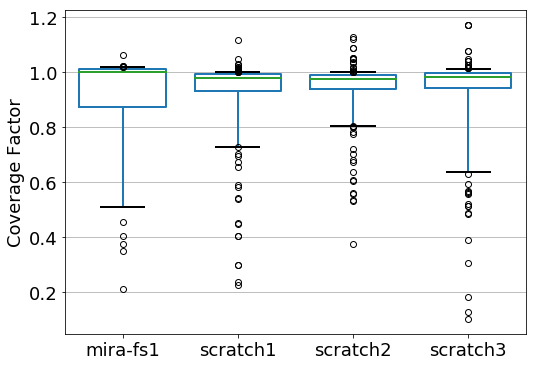

In [27]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
df_concat.boxplot(
    column=['coverage_factor'],
    by=["darshan_file_system"],
    ax=ax,
    widths=0.75,
    boxprops={'linewidth':2},
    medianprops={'linewidth':2 },
    whiskerprops={'linewidth':2},
    capprops={'linewidth':2},
    flierprops={'linewidth':2},
    whis=[5,95])
### add window dressing to plots
# plt.xticks(rotation=45)
fig.suptitle("")
ax.set_title("", fontsize=14 )
ax.set_xlabel("")
ax.set_ylabel("Coverage Factor")
ax.xaxis.grid(False)

output_file = "cf-boxplots-fs.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

Also try a coverage factor histogram since boxplots don't represent the long tail very well.

Saved cf-histogram-fs.pdf


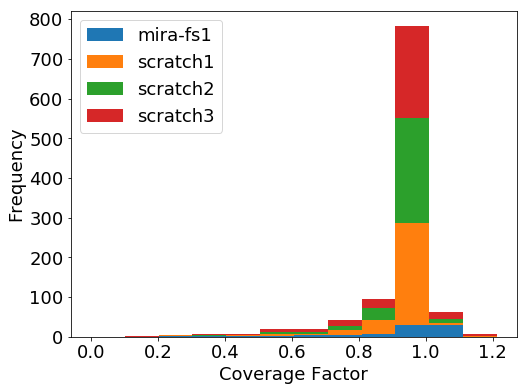

In [28]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

x = []
labels = []
for fs in df_concat['darshan_file_system'].unique():
    x.append(df_concat[df_concat["darshan_file_system"]==fs]["coverage_factor"].reset_index(drop=True).dropna())
    labels.append(fs) # in case the .unique() generator is nondeterministic
    
### retain the histogram results
histogram = ax.hist(x,
        bins=[0.101 * x for x in range(0,13)],
        label=labels,
        stacked=True
    )
# ax.yaxis.grid()
ax.legend()
ax.set_title("", fontsize=14 )
ax.set_xlabel("Coverage Factor")
ax.set_ylabel("Frequency")
fig.suptitle("")

output_file = "cf-histogram-fs.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

Calculate the cumulative distribution function (CDF) from the histogram data to get a probability distribution of observing a given coverage factor (CF).

In [29]:
for i in range(len(histogram[0])): # 4
    sums = [0 for x in range(len(histogram[0][i]))]
    for j in range(len(histogram[0][i])): # 13
        sums[j] += histogram[0][i][j]
probabilities = sums / sum(sums)
cumul = 0.0
print "%5s %6s %10s %10s" % ("CF", "Value", "CDF", "1-CDF")
for idx, probability in enumerate(probabilities):
    cumul += probability
    print "%5.3f %6.4f %10.4f %10.4f" % ( histogram[1][idx], probability, cumul, 1.0 - cumul )

   CF  Value        CDF      1-CDF
0.000 0.0000     0.0000     1.0000
0.101 0.0029     0.0029     0.9971
0.202 0.0048     0.0076     0.9924
0.303 0.0057     0.0133     0.9867
0.404 0.0067     0.0200     0.9800
0.505 0.0181     0.0381     0.9619
0.606 0.0190     0.0571     0.9429
0.707 0.0400     0.0971     0.9029
0.808 0.0914     0.1886     0.8114
0.909 0.7457     0.9343     0.0657
1.010 0.0600     0.9943     0.0057
1.111 0.0057     1.0000     0.0000


## Cumulative Distribution Functions

We now have a distribution for the coverage factor and performance.  What is the probability of getting anywhere near peak performance?  How does this vary with the coverage factor?

First calculate the cumulative distribution function for keys of interest:

In [30]:
def calculate_cdf( values ):
    """Create a pandas.Series that is the CDF of a list-like object"""

    denom = len(values) - 1
    x = sorted(values / values.max())
    y = [ i / denom for i in np.arange(len(x), dtype=np.float64) ]
    return pandas.Series( y, index=x )

In [31]:
### Calculate CDFs for (1) each file system and (2) performance and coverage factor
cdfs = {}
for fs in _FILE_SYSTEM_ORDER:
    df_fs = df_concat[df_concat['darshan_file_system'] == fs]
    for cdf_key in 'darshan_normalized_perf_by_max', 'coverage_factor':
        if cdf_key not in cdfs:
            cdfs[cdf_key] = {}
        cdf = calculate_cdf(df_fs[cdf_key])
        cdfs[cdf_key][fs] = {
            'dependent_variable':  cdf.index,
            'probability': cdf.values,
        }

In [32]:
### don't use counter_labels because the context is slightly different
cdf_labels = {
    'darshan_normalized_perf_by_max': "Fraction Peak Performance",
    'coverage_factor': "Coverage Factor",
}
cdf_file_labels = {
    'darshan_normalized_perf_by_max': "perf",
    'coverage_factor': "coverage-factor",
}

Saved cdf-both.pdf


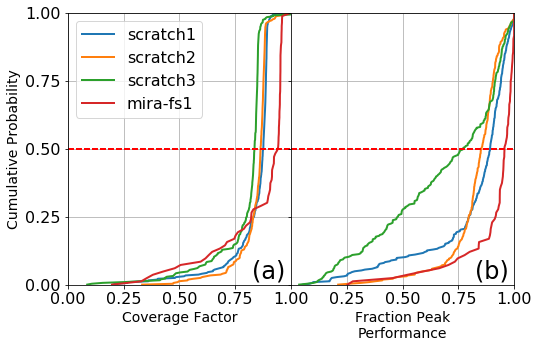

In [33]:
### Plot CDF side-by-side

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
fig.set_size_inches(8,5)

for fs in _FILE_SYSTEM_ORDER:
    for idx, cdf_key in enumerate(sorted(cdfs.keys())):
        axes[idx].plot(
                       cdfs[cdf_key][fs]['dependent_variable'],
                       cdfs[cdf_key][fs]['probability'],
                       label=fs,
                       linewidth=2)
        axes[idx].set_xlabel(wrap(cdf_labels[cdf_key]), fontsize=14)
        axes[idx].set_ylabel("")
        axes[idx].plot([0.0, 1.0],[0.5, 0.5], '--', linewidth=2.0, color='red')
        axes[idx].legend().remove()
        axes[idx].set_xticks([0.0, 0.25, 0.50, 0.75, 1.0])
        for tick in axes[idx].xaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
        for tick in axes[idx].yaxis.get_major_ticks():
            tick.label.set_fontsize(16)
axes[1].xaxis.get_major_ticks()[0].set_visible(False)
axes[0].set_title('(a)', position=(0.90,0.0), fontsize=24)
axes[1].set_title('(b)', position=(0.90,0.0), fontsize=24)
#fig.legend(
axes[0].legend(
    *(axes[0].get_legend_handles_labels()),
    fontsize=16
#   ncol=4,
#   mode="expand",
#   bbox_to_anchor=(0.11, 0.0, 0.79, 1.0),
#   loc="upper left",
#   borderaxespad=0.0
          )
axes[0].set_ylabel("Cumulative Probability", fontsize=14)
for i in 0, 1:
    axes[i].set_ylim([0.0, 1.0])
    axes[i].set_xlim([0.0, 1.0])
    axes[i].grid(True)
    axes[i].yaxis.set_ticks([0.0,0.25,0.50,0.75,1.0])
fig.suptitle("")
# fig.text(0.0, 0.5, "Cumulative Probability", va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.0, wspace=0.0)

output_file = "cdf-both.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

## IOPS Coverage Factor

In [34]:
df = df_mira.copy()
df['iops_coverage_factor'] = (df_mira['darshan_total_rws'] / (df_mira['ggio_read_reqs'] + df_mira['ggio_write_reqs']))


When performance is high, iops coverage factor is high (so application has exclusive access to iops)
When performance is low, iops coverage factor is low



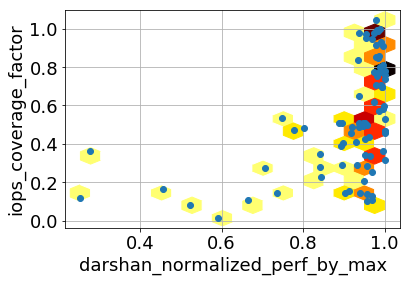

In [35]:
fig = plt.figure()
ax = fig.add_subplot('111')
x_counter = 'coverage_factor'
x_counter = 'darshan_normalized_perf_by_max'
y_counter = 'iops_coverage_factor'
ax.plot(df[x_counter],
        df[y_counter],
        marker='o',
        alpha=1.0,
        linewidth=0.0,
       )
result = ax.hexbin( df[x_counter],
            df[y_counter],
            gridsize=15,
            cmap='hot_r'
       )

ax.set_xlabel(x_counter)
ax.set_ylabel(y_counter)
ax.grid()
print """
When performance is high, iops coverage factor is high (so application has exclusive access to iops)
When performance is low, iops coverage factor is low
"""

Saved cdf-cf-bw-and-ops.pdf
Saved hist-cf-bw-and-ops.pdf


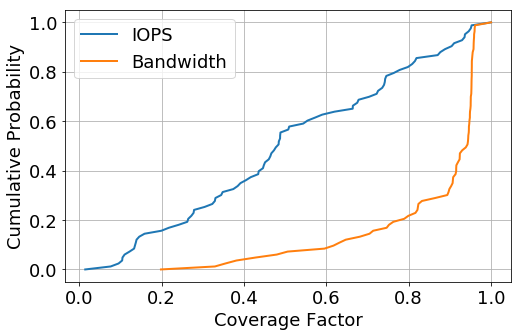

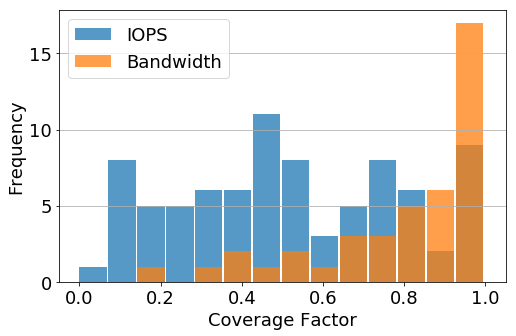

In [36]:
### CDF
fig = plt.figure()
fig.set_size_inches(8,5)
ax = fig.add_subplot("111")
ax.plot(calculate_cdf( df_mira['iops_coverage_factor'] ), label='IOPS', lw=2.0)
ax.plot(calculate_cdf( df_mira['coverage_factor'] ), label='Bandwidth', lw=2.0)
ax.set_xlabel("Coverage Factor")
ax.set_ylabel("Cumulative Probability")
ax.legend()
ax.grid()
output_file = "cdf-cf-bw-and-ops.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file


### Also try bar plots
fig = plt.figure()
fig.set_size_inches(8,5)
ax = fig.add_subplot("111")
y1 = df_mira['iops_coverage_factor']
y2 = df_mira['coverage_factor']
common_opts = {
                "width": 1.0/15.0,
                "bins": np.linspace(0.0, 1.0, 15),
                'alpha': 0.75,
                'lw': 3.0,
#                 'zorder': 9,
              }

# ax.hist( [ y1, y2 ], label=["IOPS", "Bandwidth"], **common_opts)
for y, label in [ 
                 (y1, 'IOPS'),
                 (y2, 'Bandwidth'),

                ]:
    ax.hist( y, label=label, **common_opts)

ax.set_xlabel("Coverage Factor")
ax.set_ylabel("Frequency")
ax.legend()
ax.yaxis.grid()
output_file = "hist-cf-bw-and-ops.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

# Statistical Analysis of TOKIO-ABC Results

This notebook performs various statistical analyses of the summary data generated by each TOKIO-ABC job.  These data are loaded from __a summary csv file__ where each row represents a single job and contains the relevant data extracted from

1. the darshan log
2. the server-side I/O monitoring (Lustre LMT or GPFS GGIOSTAT)
3. optional system-specific monitoring including
    - OST health info (Lustre)
    - Concurrent job count (Slurm)
    - Job radius (Cray XC)
    
This input CSV is generated at NERSC by

1. running `utils/nersc_generate_job_summary.sh` to generate json summary records for each darshan log
2. running `utils/json2csv.py` to convert all jsons into a single csv file

This script is used to identify interesting patterns and correlations across jobs.  For intra-job inspection, use other analysis notebooks such as `analysis/per_ost_deep_dive.ipynb`.

In [37]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 18})
plt.rcParams['image.cmap'] = 'gray'
import matplotlib.gridspec
import os

In [38]:
import pandas
import numpy as np
import scipy
import scipy.stats as stats
import scipy.interpolate
import json
import datetime
import bisect
import warnings
import textwrap

### black magic necessary for processing Mira log files :(
try:
    import pytz
    _USE_TZ = True
except ImportError:
    _USE_TZ = False

def wrap(text, width=15):
    """wrapper for the wrapper"""
    return '\n'.join(textwrap.wrap(text=text,width=width))

In [39]:
def utc_timestamp_to_YYYYMMDD( timestamp ):
    """
    This is a batty function that allows us to compare the UTC-based
    timestamps from Darshan logs (start_time and end_time) to the
    Chicago-based YYYY-MM-DD dates used to index the mmdf data.
    """
    if _USE_TZ:
        ### we know that these logs are from Chicago
        tz = pytz.timezone("America/Chicago")
        
        ### Darshan log's start time in UTC, so turn it into a datetime with UTC on it
        darshan_time = pytz.utc.localize(datetime.datetime.utcfromtimestamp(timestamp))
        
        ### Then convert this UTC start time into a local start time so
        ### we can compare it to the local mmdf timestamp
        darshan_time_at_argonne = darshan_time.astimezone(tz)
        return darshan_time_at_argonne
    else:
        ### we assume that this script is running on Argonne time; it's the best we can do
        warnings.warn("pytz is not available so mmdf data might be misaligned by a day!")
        return datetime.datetime.fromtimestamp(timestamp)

In [40]:
### Relative path to the repository's root directory
_REPO_BASE_DIR = os.path.join('..', '..')

### Translates cryptic counter names into something suitable for labeling plots
counter_labels = json.load(open(os.path.join(_REPO_BASE_DIR, 'scripts', 'counter_labels.json'), 'r'))

### For consistency, always plot file systems in the same order
_FILE_SYSTEM_ORDER = [ 'scratch1', 'scratch2', 'scratch3', 'mira-fs1' ]

In [41]:
def plot_corr(df,size=20):
    """
    Function plots a graphical correlation matrix for each pair
    of columns in the dataframe.  From
    
    http://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot
    """
    matplotlib.rc('xtick', labelsize=20)
    matplotlib.rc('ytick', labelsize=20)
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr, cmap=plt.get_cmap('seismic'),
                    norm=matplotlib.colors.Normalize(vmin=-1.,vmax=1.) )
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    return corr

## Load data

We've been storing most of the per-job summary data in a single CSV per system.  We

1. Load the CSV directly into a dataframe
2. Drop any rows containing NANs, because if any of the core data is missing (e.g., application name), the whole record is useless.  Hopefully I haven't overlooked anything important in this assumption.
3. Synthesize a few new columns (we call these "metrics" in the paper) to facilitate downstream analysis

In [42]:
### Edison
df_edison = pandas.DataFrame.from_csv(os.path.join(_REPO_BASE_DIR,
                                                   'data',
                                                   'dat',
                                                   'tokio-lustre',
                                                   'edison-abc-stats_2-14_3-23.csv')).dropna()
df_edison['darshan_rw'] = [ 'write' if x == 1 else 'read' for x in df_edison['darshan_write_mode?'] ]
df_edison['darshan_file_mode'] = [ 'shared' if x in ['H5Part','MPIIO'] else 'fpp' for x in df_edison['darshan_api'] ]
df_edison.rename(columns={'lmt_bytes_covered': 'coverage_factor'}, inplace=True)
df_edison['system'] = "edison"
df_edison['iops_coverage_factor'] = -1.0

### Mira
df_mira = pandas.DataFrame.from_csv(os.path.join(_REPO_BASE_DIR,
                                                'data',
                                                'dat',
                                                'tokio-gpfs',
                                                'alcf-abc-stats_2-25_3-19.dat')).dropna()
rename_dict = { '# platform': "system" }
for key in df_mira.keys():
    if key == 'file_sys':
        rename_dict[key] = 'darshan_file_system'
    elif key not in rename_dict and not key.startswith('ggio_'):
        rename_dict[key] = 'darshan_' + key
df_mira.rename(columns=rename_dict, inplace=True)
df_mira['darshan_file_mode'] = [ 'shared' if x in ['H5Part','MPIIO'] else 'fpp' for x in df_mira['darshan_api'] ]
df_mira['coverage_factor'] = df_mira['darshan_total_bytes'] / (df_mira['ggio_bytes_read'] + df_mira['ggio_bytes_written'])
df_mira['iops_coverage_factor'] = (df_mira['darshan_total_rws'] / (df_mira['ggio_read_reqs'] + df_mira['ggio_write_reqs']))

Because I'm lazy, load the `mmdf` data separately and attach it to `df_mira`.

In [43]:
#df_mmdf = pandas.DataFrame.from_csv(os.path.join(_REPO_BASE_DIR,
df_mmdf = pandas.DataFrame.from_csv(os.path.join(_REPO_BASE_DIR,
                                                'data',
                                                'dat',
                                                'tokio-gpfs',
                                                'mira_mmdf_1-25_3-23.csv'),
                                        index_col=['file_system', 'date'])
df_mmdf['free_kib'] = df_mmdf['free_kib_blocks'] + df_mmdf['free_kib_frags']
df_mmdf['free_pct'] = df_mmdf['free_kib'] / df_mmdf['disk_size']

Walk the master dataframe and attach mmdf data.  Note that we're injecting NAs for missing mmdf data because missing mmdf data should not exclude the entire day from our analysis.

In [44]:
### I really hope iterrows behaves deterministically and preserves order...
new_data = {
    'mmdf_avg_fullness_pct': [],
    'mmdf_max_fullness_pct': [],
}

### iterate over each row of the master Mira dataframe
for row in df_mira.itertuples():
    fs_key = row.darshan_file_system
    mmdf_key = utc_timestamp_to_YYYYMMDD( row.darshan_start_time ).strftime("%Y-%m-%d")
    if mmdf_key in df_mmdf.loc[fs_key].index:
        ### only look at today's data
        df = df_mmdf.loc[fs_key].loc[mmdf_key]
        
        data_cols = [ True if x else False for x in df['data?'] ]

        ### calculate a percent fullness - don't bother saving the id of this fullest server though
        new_data['mmdf_max_fullness_pct'].append( 1.0 - df[ data_cols ]['free_pct'].min() )
        new_data['mmdf_avg_fullness_pct'].append( 1.0 - df[ data_cols ]['free_pct'].mean() )
    else:
        warnings.warn("no mmdf data for %s" % datetime.datetime.fromtimestamp(row.darshan_start_time) )
        new_data['mmdf_max_fullness_pct'].append( np.nan )
        new_data['mmdf_avg_fullness_pct'].append( np.nan )

for new_col_name, new_col_data in new_data.iteritems():
    df_mira[new_col_name] = new_col_data

/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: no mmdf data for 2017-02-24 20:17:41
/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: no mmdf data for 2017-02-24 20:19:39
/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: no mmdf data for 2017-02-24 20:21:34
/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: no mmdf data for 2017-02-24 20:24:33
/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: no mmdf data for 2017-02-24 20:29:40
/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: no mmdf data for 2017-02-24 20:30:58
/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: no mmdf data for 2017-02-26 02:04:26
/Users/glock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: no mmdf data for 2017-02-26 0

Now merge both DataFrames so we can look at all the data if we really want to.  This DataFrame will have a bunch of NANs for data that is only applicable to Mira or Edison.

In [45]:
df_concat = pandas.concat( (df_mira, df_edison) )

## Filter Data

Two notable filters are applied:

1. All jobs where the bytes coverage factor and ops coverage factor are greater than 1.2 are discarded because they reflect severely misaligned or gappy data.

2. Mira job 1039807 is excluded because ggiostat returned highly abnormal results starting that day.  See e-mail from Shane and Phil on March 23 about this.

3. All Edison jobs from March 12 were discarded because LMT broke as a result of daylight saving time rolling over.  This filter was applied _before_ the input CSV files loaded above were generated, so it does not need to be applied here.

In [46]:
for df in df_mira, df_edison, df_concat:
    df.drop(df.index[df['coverage_factor'] > 1.2], inplace=True)
    df.drop(df.index[df['iops_coverage_factor'] > 1.2], inplace=True)
    
    df.drop(df.index[(df['system'] == 'mira') & (df['darshan_jobid'] == 1039807)], inplace=True)

In [47]:
df_mira

,system,darshan_file_system,darshan_app,darshan_api,darshan_rw,darshan_io_time,darshan_agg_perf_by_slowest,darshan_total_bytes,darshan_total_opens,darshan_total_rws,...,ggio_closes,ggio_read_reqs,ggio_write_reqs,ggio_read_dirs,ggio_inoded_updates,darshan_file_mode,coverage_factor,iops_coverage_factor,mmdf_max_fullness_pct,mmdf_avg_fullness_pct
72,mira,mira-fs1,IOR,MPIIO,write,76.156770,13768.651149,1099511627776,32769,66560,...,57010.0,68804.0,160444.0,147.0,3565.0,shared,0.971512,0.290341,NaN,NaN
73,mira,mira-fs1,IOR,POSIX,write,94.955053,11042.866815,1099511627776,16384,262144,...,53457.0,212215.0,279447.0,0.0,59051.0,fpp,0.405680,0.533179,NaN,NaN
74,mira,mira-fs1,HACC-IO,GLEAN,write,97.271743,16169.796119,1649267703808,32768,163840,...,48093.0,361163.0,214518.0,0.0,60652.0,fpp,0.509942,0.284602,NaN,NaN
75,mira,mira-fs1,IOR,MPIIO,read,134.328639,7806.049436,1099511627776,32768,66560,...,55069.0,827368.0,7102.0,13.0,1627.0,shared,0.210950,0.079763,NaN,NaN
76,mira,mira-fs1,IOR,POSIX,read,64.341811,16296.961351,1099511627776,16384,262144,...,44894.0,543249.0,1347.0,0.0,4875.0,fpp,0.377185,0.481355,NaN,NaN
77,mira,mira-fs1,HACC-IO,GLEAN,read,120.673670,13034.030111,1649267703808,32768,163840,...,37523.0,594288.0,2613.0,0.0,7350.0,fpp,0.455154,0.274484,NaN,NaN
78,mira,mira-fs1,IOR,MPIIO,write,75.530148,13882.880301,1099511627776,32769,66560,...,632991.0,306444.0,150988.0,0.0,132.0,shared,0.875651,0.145508,NaN,NaN
79,mira,mira-fs1,IOR,POSIX,write,75.830827,13827.832849,1099511627776,16384,262144,...,89160.0,43309.0,270772.0,0.0,53648.0,fpp,1.004168,0.834638,NaN,NaN
80,mira,mira-fs1,HACC-IO,GLEAN,write,95.630948,16447.230528,1649267703808,32768,163840,...,86867.0,46543.0,219012.0,13.0,62839.0,fpp,0.982406,0.616972,NaN,NaN
82,mira,mira-fs1,IOR,POSIX,read,54.041716,19403.084972,1099511627776,16384,262144,...,93775.0,271271.0,4059.0,0.0,14052.0,fpp,1.006043,0.952108,NaN,NaN


## Normalize Performance
Different file systems, benchmarks, and read/write modes are capable of different peak bandwidths.  As such, we want to normalize the absolute performance (`summarize_key`) by something.  For convenience we calculate the denominator for normalization a couple of different ways (e.g., the mean, median, and max measurement).  We also limit normalization to unique combinations of variables specified by `normalization_group` below.

Calculate the normalization factors (the denominators), then apply that factor to all of the data in the DataFrame.  These normalized data will be saved as new columns in the DataFrame.

In [48]:
### The actual variable we want to normalize
summarize_key = 'darshan_agg_perf_by_slowest'

for df in df_edison, df_mira, df_concat:
    ### Specify which keys we want to group together before normalizing
    normalization_group = df.groupby(['darshan_app', 'darshan_file_system', 'darshan_file_mode', 'darshan_rw'])

    ### Dict to store the denominators for normalization
    normalization_data = {
        'mean':   normalization_group.darshan_agg_perf_by_slowest.mean(),
        'median': normalization_group.darshan_agg_perf_by_slowest.median(),
        'max':    normalization_group.darshan_agg_perf_by_slowest.max(),
    }

    ### Normalize every row in the DataFrame by all of our denominators
    new_cols = {}
    for func in normalization_data.keys():
        new_col_key = 'darshan_normalized_perf_by_%s' % func
        new_cols[new_col_key] = []
        for index, row in df.iterrows():
            new_cols[new_col_key].append(
                row[summarize_key] / normalization_data[func]
                                                       [row['darshan_app']]
                                                       [row['darshan_file_system']]
                                                       [row['darshan_file_mode']]
                                                       [row['darshan_rw']]
            )

    ### Also just do per-file system
    normalization_group = df.groupby('darshan_file_system')
    normalization_data = {
        'mean':   normalization_group.darshan_agg_perf_by_slowest.mean(),
        'median': normalization_group.darshan_agg_perf_by_slowest.median(),
        'max':    normalization_group.darshan_agg_perf_by_slowest.max(),
    }
    for func in normalization_data.keys():
        new_col_key = 'darshan_normalized_perf_by_fs_%s' % func
        new_cols[new_col_key] = []
        for index, row in df.iterrows():
            new_cols[new_col_key].append(
                row[summarize_key] / normalization_data[func][row['darshan_file_system']])

    ### Take our normalized data and add them as new columns
    for new_col, new_col_data in new_cols.iteritems():
        df[new_col] = new_col_data

## Multivariate Correlation Analysis
`performance_key` is the variable we wish to use to represent performance.  It is typically

- `darshan_agg_perf_by_slowest`, which is the absolute performance measured by each benchmark run
- `darshan_normalized_perf_by_max`, which is normalized by the maximum observed performance
- `darshan_normalized_perf_by_mean`, which is normalized by the mean observed performance

In [49]:
performance_key = 'darshan_normalized_perf_by_max'

### Pearson Correlation Analysis
Pearson analysis assumes that each variable is normally distributed.  It is easier to understand, but it is not technically correct for variables that are _not_ normally distributed, which include performance.  The Spearman coefficient would be better.

At any rate, this correlation matrix is not of interest to this paper so don't bother generating it here.

In [50]:
### make a pretty plot to flag highlights
if False:
    corr_edison = plot_corr(df_edison[
        (df_edison['darshan_file_system'] == 'scratch1') 
        | (df_edison['darshan_file_system'] == 'scratch2') 
        | (df_edison['darshan_file_system'] == 'scratch3')
    ], 10)
    corr_mira = plot_corr(df[df['darshan_file_system'] == 'mira-fs1'], 10)

### Numerical Correlation Analysis
Now we repeat this correlation analysis, but this time use `scipy.stats` instead of `pandas` so that we can calculate p-values associated with each correlation.  The ultimate artifact of this process is a table of interesting correlations, their correlation coefficients, and color coding to indicate the confidence of those coefficients based on p-values.

In [51]:
ignore_cols = [
    'lmt_tot_zeros',
    'lmt_frac_zeros',
    'lmt_frac_missing',
    'ost_avg_kib',
    'ost_min_pct',
    'ost_min_kib',
    'ost_max_kib',
    'ost_count',
#   'ost_bad_ost_count',
    'ost_bad_ost_pct',
    'ost_failures_lead_secs',
    'ost_fullness_lead_secs',
    'lmt_tot_missing',
    'ost_avg_bad_ost_per_oss',
    'ost_avg_bad_overload_factor',
    'ost_bad_oss_count',
    'ost_min_id',
    'ost_max_id',
    'job_min_radius',
    'job_avg_radius',
### second pass
    'lmt_ops_getattrs',
    'lmt_ops_getxattrs',
    'lmt_ops_rmdirs',
    'lmt_ops_unlinks',
    'lmt_ops_renames',
    'lmt_ops_setattrs',
    'lmt_ops_mkdirs',
    'ggio_inoded_updates',
### third pass
    "lmt_mds_ave",
    "lmt_oss_ave",
]

### if one key has the same logical meaning as another, this will remap those
### keys so they line up in the DataFrame
equivalent_keys = {
    'ggio_closes':     'lmt_ops_closes',
    'ggio_opens': 'lmt_ops_opens',
    'ggio_bytes_read': 'lmt_tot_bytes_read',
    'ggio_bytes_written': 'lmt_tot_bytes_write',
    'mmdf_max_fullness_pct': 'ost_max_pct',
    'mmdf_avg_fullness_pct': 'ost_avg_pct',
}

### Specific names for the table
counter_labels_table = {
    'coverage_factor': "Coverage Factor (Bandwidth)",
    "ost_avg_pct": "Avg LUN Fullness",
    "ost_max_pct": "Fullness on Fullest LUN",
    "lmt_oss_max": "Max CPU Load, Data Server",
    "ost_bad_pct": "% Servers Failed Over",
    "lmt_ops_closes": "close(2) Calls",
    "lmt_ops_opens": "open(2) Calls",
    "lmt_tot_bytes_write": "Bytes Written",
    "lmt_tot_bytes_read": "Bytes Read",
    "lmt_mds_max": "Max CPU Load, Metadata Server",
    "lmt_mds_ave": "Avg CPU Load, Metadata Server",
    "job_concurrent_jobs": "# Concurrent Jobs",
    "lmt_oss_ave": "Avg CPU Load, Data Server",
    "job_max_radius": "Job Diameter",
    "iops_coverage_factor": "Coverage Factor (IOPS)",
    "ggio_write_reqs": "Write Ops",
    "ggio_read_reqs": "Read Ops",
}

### Order in which table is to be printed
print_order = [
    'coverage_factor',
    "iops_coverage_factor",
    "lmt_ops_closes",
    "lmt_ops_opens",
    "lmt_tot_bytes_write",
    "lmt_tot_bytes_read",
    "ggio_write_reqs",
    "ggio_read_reqs",
    "ost_max_pct",
    "ost_avg_pct",
    "lmt_mds_max",
    "lmt_oss_max",
    "ost_bad_pct",
    "job_concurrent_jobs",
    "job_max_radius",
]

In [52]:
def correlation_calculation(df,
                            analysis_func=stats.pearsonr,
                            only_print_key=performance_key,
                            ignore_cols=[],
                            max_pval=1.01):
    """
    Calculate the Pearson correlation coefficient and the associated
    p-value for various counter pairs.  If only_print_key is None,
    every possible combination of columns in df is attempted; otherwise,
    the column identified by only_print_key is compared against all other
    columns.
    """
    num_cols = len(df.keys())
    results = []
    
    if only_print_key is None:
        i_range = range(num_cols - 1)
    else:
        i_range = [ list(df.columns).index(only_print_key) ]

    for i in i_range:
        i_col = df.columns[i]
        if only_print_key is None:
            j_range = range(i, num_cols)
        else:
            j_range = range(len(df.columns))
            j_range.remove(i_range[0]) # degenerate case
        for j in j_range:
            j_col = df.columns[j]
            try:
                ### The Scipy stats package barfs if x or y contain any
                ### NANs, but we don't want to drop all records that
                ### contain any nans.  So, we wait until the very last
                ### minute to drop only those columns that contain nans
                ### that we would otherwise try to correlate.
                df_corr = df[[i_col, j_col]].dropna()
                coeff, pval = analysis_func(df_corr[i_col],
                                            df_corr[j_col])
            except TypeError: # non-numeric column
                continue
            results.append((i_col,
                            j_col,
                            coeff,
                            pval))

    ### now start dropping correlations that we don't want/need
    sorted_results = sorted(results, key=lambda x: x[3])
    ret_results = []
    for col_name1, col_name2, coeff, pval in sorted_results:
        ### don't print trivial relationships
        if pval == 0 or pval == 1:
            continue
        ### don't print relationships with very high p-values
        if pval > max_pval:
            continue
        ### don't correlate data from the same source since much of it is degenerate
        if col_name1.split('_',1)[0] == col_name2.split('_',1)[0]:
            continue
        ### don't print anything except for the key of interest (if provided)
        if only_print_key is not None \
        and col_name1 != only_print_key \
        and col_name2 != only_print_key:
            continue
        if col_name1 in ignore_cols or col_name2 in ignore_cols:
            continue
#       print "%10.4f %10.4g %30s : %-15s" % (coeff, pval, col_name1, col_name2)
        
        ### sort the output key orders
        if col_name1 == only_print_key:
            ret_results.append([col_name1,col_name2,coeff,pval])
        elif col_name2 == only_print_key:
            ret_results.append([col_name2,col_name1,coeff,pval])
        else:
            if col_name2 > col_name1:
                ret_results.append([col_name1,col_name2,coeff,pval])
            else:
                ret_results.append([col_name2,col_name1,coeff,pval])
    return ret_results

In [53]:
### Calculate correlations between performance and everything else
correlations = {}

correlations['edison'] = correlation_calculation(df_edison, ignore_cols=ignore_cols)
correlations['mira'] = correlation_calculation(df_mira, ignore_cols=ignore_cols)
### to_df: dict we will use to store arrays -> pd.Series
to_df = {}

### common_key: needed to figure out which key is the independent variable
common_key = None

### list that will become dataframe index
key_index = []

### loop over all systems, all correlations, all pairs of variables
for system, records in correlations.iteritems():
    for row in records:
        ### try to figure out which of the two keys is not repeated
        if common_key is None:
            common_key = row[0]
        if row[0] != common_key:
            common_key = row[1]
            unique_key = row[0]
        else:
            unique_key = row[1]

        ### convert compatible key names from ggio_ to lmt_
        if unique_key in equivalent_keys:
            unique_key = equivalent_keys[unique_key]

        ### build up a list of keys that will be our Index
        if unique_key not in key_index:
            key_index.append(unique_key)
            
        ### fill out the dict 
        counterkey = "counter_%s" % system
        corrkey = 'correlation_%s' % system
        pvalkey = 'p-value_%s' % system
        if counterkey not in to_df: to_df[counterkey] = []
        if corrkey not in to_df: to_df[corrkey] = []
        if pvalkey not in to_df: to_df[pvalkey] = []
        to_df[counterkey].append(unique_key)
        to_df[corrkey].append(row[2])
        to_df[pvalkey].append(row[3])

### Make an empty but indexed data frame
df = pandas.DataFrame(index=key_index)
for system in correlations.keys():
    counterkey = "counter_%s" % system
    corrkey = 'correlation_%s' % system
    pvalkey = 'p-value_%s' % system

    df[corrkey] = pandas.Series(to_df[corrkey], index=to_df[counterkey])
    df[pvalkey] = pandas.Series(to_df[pvalkey], index=to_df[counterkey])

df

,correlation_edison,p-value_edison,correlation_mira,p-value_mira
coverage_factor,0.437681,1.785791e-46,0.375883,0.000426
ost_avg_pct,-0.384375,2.275931e-35,0.061464,0.621231
ost_max_pct,-0.366718,4.070626e-32,0.061193,0.622774
lmt_oss_max,-0.237031,8.384589e-14,NaN,NaN
ost_bad_pct,0.175406,4.082602e-08,NaN,NaN
ost_bad_ost_count,0.175406,4.082602e-08,NaN,NaN
lmt_ops_closes,-0.102514,1.420340e-03,-0.280064,0.009874
lmt_ops_opens,-0.101647,1.559697e-03,-0.277375,0.010636
lmt_tot_bytes_write,-0.089701,5.271314e-03,-0.038061,0.731050
lmt_mds_max,-0.082880,9.964685e-03,NaN,NaN


                   ost_max_pct pval=    0.6228; setting color to red
                lmt_ops_closes pval=    0.0014; setting color to blue
          iops_coverage_factor pval=    0.0000; setting color to blue
           job_concurrent_jobs pval=    0.1270; setting color to red
           lmt_tot_bytes_write pval=    0.7310; setting color to red
                 lmt_ops_opens pval=    0.0016; setting color to blue
                   ost_max_pct pval=    0.0000; setting color to blue
                ggio_read_reqs pval=    0.0004; setting color to blue
                job_max_radius pval=    0.7728; setting color to red
           lmt_tot_bytes_write pval=    0.0053; setting color to blue
                   ost_avg_pct pval=    0.0000; setting color to blue
                 lmt_ops_opens pval=    0.0106; setting color to green
               coverage_factor pval=    0.0004; setting color to blue
               ggio_write_reqs pval=    0.0022; setting color to blue
            lmt_tot_byt

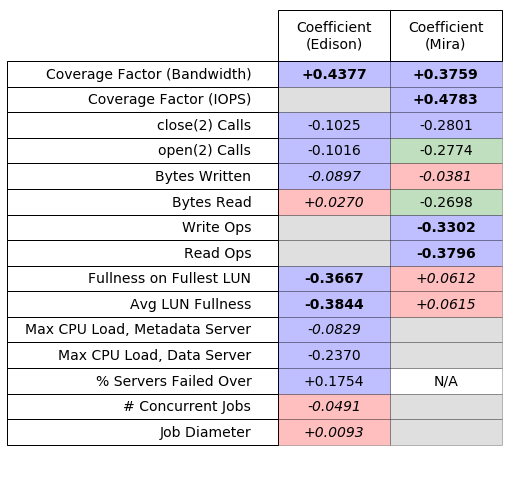

In [54]:
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(111)

column_headers = {
    "correlation_edison": "Coefficient\n(Edison)",
    "correlation_mira": "Coefficient\n(Mira)",
    "p-value_edison": "P-value (Edison)",
    "p-value_mira": "P-value (Mira)",
}

coefficient_keys = [x for x in df.columns if x.startswith('correlation_')]

### the index is column -1
table = pandas.tools.plotting.table(ax,
                            df[coefficient_keys].reindex(print_order),
                            loc='upper right',
                            colWidths=[0.8,0.8,3.8],
                            bbox=[0, 0, 1, 1])
table.set_fontsize(14)
ax.axis('tight')
ax.axis('off')

### Rewrite the contents of the table that Pandas gave us
cells_dict = table.get_celld()
remap_values = {}
for cell_pos, cell_obj in cells_dict.iteritems():
    i, j = cell_pos
    value = cell_obj.get_text().get_text()
    height_scale = 1.0
    if i == 0:    # column headers
        remap_values[cell_pos] = column_headers.get(value, value)
        height_scale = 2.0
    elif j == -1: # index cell
        remap_values[cell_pos] = counter_labels_table.get(value, value)
        cell_obj._loc = 'right'
    else:         # coefficient cell
        index = cells_dict[(i,-1)].get_text().get_text()
        column = cells_dict[(0,j)].get_text().get_text()
        if value == "nan":
            if index == 'ost_bad_pct' and column == "correlation_mira":
                remap_values[cell_pos] = "N/A"
                cell_obj.set_color('white')
            else:
                cell_obj.set_color('grey')
                remap_values[cell_pos] = ""
            cell_obj.set_alpha(0.25)
            cell_obj._loc = 'center'
        else:
            coeff = float(value)
            pval = df.loc[index][column.replace('correlation','p-value')]

            ### make moderate correlations **bold**
            if abs(coeff) >= 0.30:
                cell_obj.get_text().set_fontweight('bold')
            elif abs(coeff) < 0.10:
                cell_obj.get_text().set_fontstyle('italic')

            ### color code cells based on p-value
            if pval < 0.01:
                set_color = 'blue'
            elif pval < 0.05:
                set_color = 'green'
            else:
                set_color = 'red'
            
            ### for debugging, since the resulting figure doesn't contain any p-values
            print "%30s pval=%10.4f; setting color to %s" % (
                index, pval, set_color
            )
            cell_obj.set_color(set_color)
            cell_obj.set_alpha(0.25)
            cell_obj._loc = 'center'
            remap_values[cell_pos] = "%+.4f" % coeff
    cell_obj.set_height(height_scale * cell_obj.get_height())
    cell_obj.set_edgecolor('black')

### Actually rewrite the cells now
for cell_pos, new_value in remap_values.iteritems():
    cells_dict[cell_pos].get_text().set_text(new_value)
    
output_file = "correlation_table.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

### Scatter Plots
To visualize these correlations, we define pairs of counters to plot against each other:

In [55]:
scatterplots = [ 
    (performance_key, 'coverage_factor'),
    (performance_key, 'lmt_oss_ave'),
    (performance_key, 'job_concurrent_jobs'),
    (performance_key, 'ost_avg_pct'),
    (performance_key, 'ost_max_kib'),
    (performance_key, 'coverage_factor'),
    (performance_key, 'ggio_write_reqs'),
    (performance_key, 'ggio_write_reqs'),
]

...and then plot them:

Saved scatter_darshan_normalized_perf_by_max_vs_coverage_factor.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_lmt_oss_ave.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_job_concurrent_jobs.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_ost_avg_pct.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_coverage_factor.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_ggio_write_reqs.pdf
Saved scatter_darshan_normalized_perf_by_max_vs_ggio_write_reqs.pdf


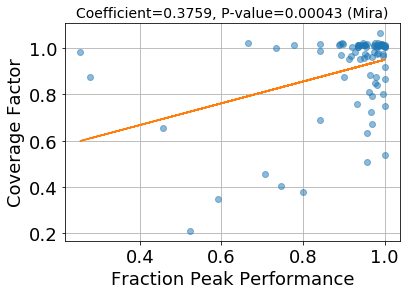

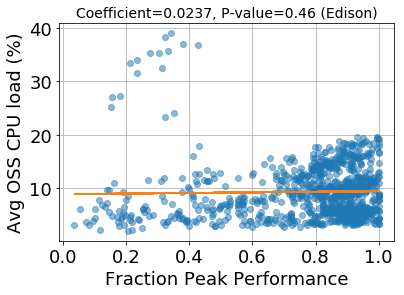

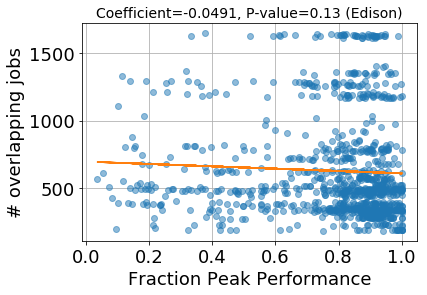

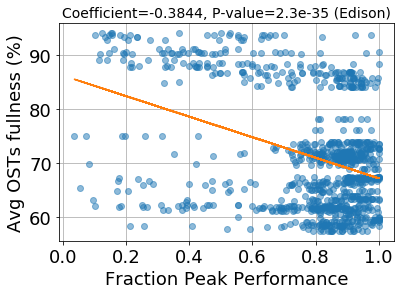

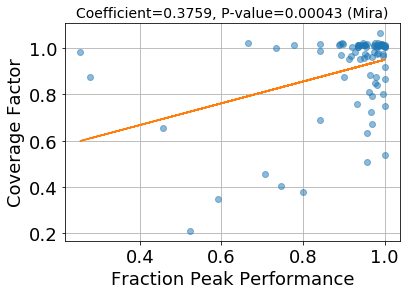

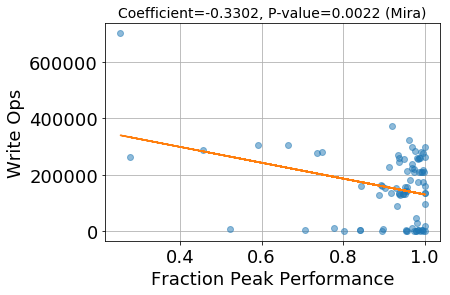

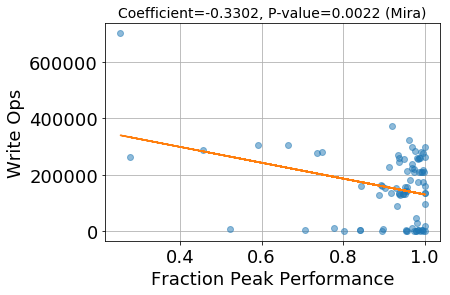

In [56]:
blacklist = set([
    'ost_max_id', 'ost_min_id', 'lmt_tot_zeros',
    'ost_failures_lead_secs', 'ost_fullness_lead_secs',
    'ost_max_kib', 'ost_avg_kib', 'ost_min_kib', 
    'lmt_tot_missing'
])
# for scatterplot in correlations_edison + correlations_mira:
for scatterplot in scatterplots:
    x_key = scatterplot[0]
    y_key = scatterplot[1]
    if x_key in blacklist or y_key in blacklist:
        continue
    if y_key in df_mira :
        df_plot = df_mira
        system = "Mira"
    elif y_key in df_edison:
        df_plot = df_edison
        system = "Edison"
    else:
        warnings.warn("Cannot find key %s in any data frames" % y_key)
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    
    x = df_plot[x_key].values
    x_label = counter_labels.get(x_key, x_key)
    y = df_plot[y_key].values
    y_label = counter_labels.get(y_key, y_key)
#   ax.hexbin(x, y, gridsize=25, cmap='PuRd')
    ax.plot(x, y, 'o', alpha=0.5)

    ### attempt a linear fit to generate a visual aid
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x+b, "-")
    
    ### add window dressing to plots
#   fig.suptitle('Correlation between %s and %s' 
#                 % (x_label.split('(',1)[0].strip(),
#                    y_label.split('(',1)[0].strip()))
    ax.set_title("Coefficient=%.4f, P-value=%.2g (%s)" 
                    % sum((stats.pearsonr(x, y), (system,)), ()), fontsize=14 )
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.grid(True)
    output_file = "scatter_%s_vs_%s.pdf" % (x_key, y_key)
    fig.savefig(output_file, bbox_inches="tight")
    print "Saved %s" % output_file

Mira also has both server-side and client side IOPS.  Let's look at those specifically:

Write Ops -0.330181646216 0.00215977302826
Read Ops -0.379631069251 0.000368665826371
Saved scatter_mira_ops.pdf


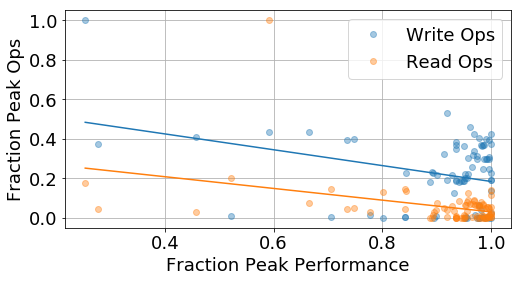

In [57]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

df = df_mira.sort_values(performance_key).copy()

for x_key, y_key in [(performance_key, 'ggio_write_reqs'),
                    (performance_key, 'ggio_read_reqs')]:
    x = df[x_key].values
    y = df[y_key].values / df[y_key].max()
    corr = stats.pearsonr(x, y)
    print counter_labels.get(y_key, y_key), corr[0], corr[1]
    points = ax.plot(x, y,
                     'o',
                     alpha=0.4,
                     markersize=6.0,
                     label="%s" % (counter_labels.get(y_key, y_key))
                    )
        
    ### attempt a linear fit to generate a visual aid
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x+b,
            "-",
           color=points[0].get_color())
    
ax.set_xlabel(counter_labels.get(x_key, x_key))
ax.set_ylabel("Fraction Peak Ops")
ax.legend()
plt.grid(True)
output_file = "scatter_mira_ops.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

iops_coverage_factor 0.420121233262 6.93435261987e-05
Saved scatter_mira_ops.pdf


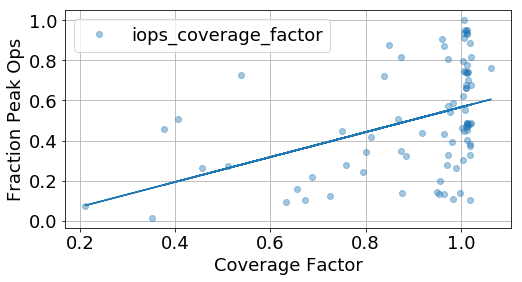

In [58]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

df = df_mira.sort_values(performance_key).copy()

for x_key, y_key in [('coverage_factor', 'iops_coverage_factor')]:
    x = df[x_key].values
    y = df[y_key].values / df[y_key].max()
    corr = stats.pearsonr(x, y)
    print counter_labels.get(y_key, y_key), corr[0], corr[1]
    points = ax.plot(x, y,
                     'o',
                     alpha=0.4,
                     markersize=6.0,
                     label="%s" % (counter_labels.get(y_key, y_key))
                    )
        
    ### attempt a linear fit to generate a visual aid
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x+b,
            "-",
           color=points[0].get_color())
    
ax.set_xlabel(counter_labels.get(x_key, x_key))
ax.set_ylabel("Fraction Peak Ops")
ax.legend()
plt.grid(True)
output_file = "scatter_mira_ops.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

Plot the correlation between coverage factor and performance for each file system separately

Saved scatter_perf-vs-cf_scratch1.pdf
Saved scatter_perf-vs-cf_scratch1.pdf
Saved scatter_perf-vs-cf_scratch1.csv
Saved scatter_perf-vs-cf_scratch2.pdf
Saved scatter_perf-vs-cf_scratch2.pdf
Saved scatter_perf-vs-cf_scratch2.csv
Saved scatter_perf-vs-cf_scratch3.pdf
Saved scatter_perf-vs-cf_scratch3.pdf
Saved scatter_perf-vs-cf_scratch3.csv
Saved scatter_perf-vs-cf_mira-fs1.pdf
Saved scatter_perf-vs-cf_mira-fs1.pdf
Saved scatter_perf-vs-cf_mira-fs1.csv


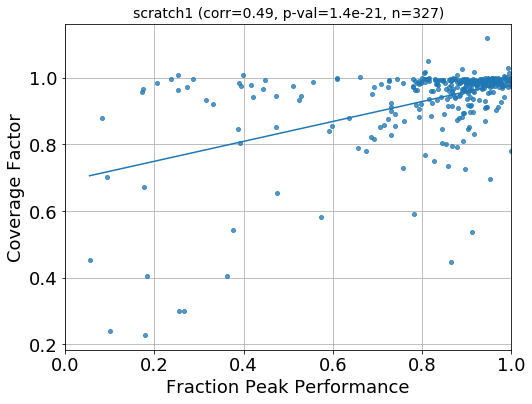

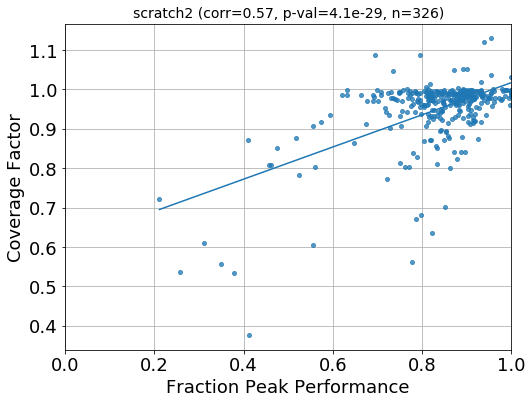

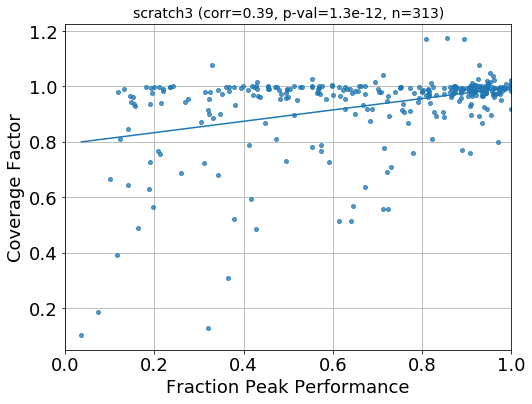

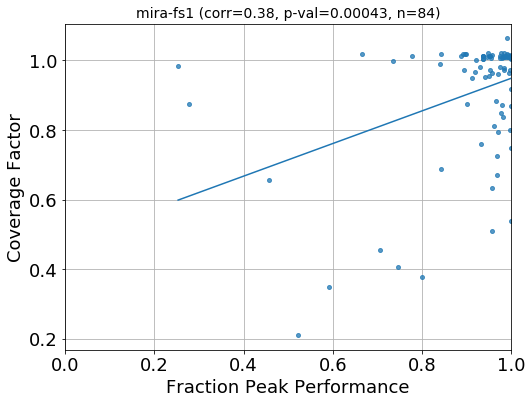

In [59]:
# for scatterplot in correlations_mira:
for idx, fs in enumerate(_FILE_SYSTEM_ORDER):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    x_key = performance_key
    y_key = 'coverage_factor'
    if fs.startswith('mira') :
        df_plot = df_mira.sort_values(performance_key)
        system = "Mira"
    elif fs.startswith('scratch'):
        df_plot = df_edison.sort_values(performance_key)
        system = "Edison"
    else:
        warnings.warn("Cannot find key %s in any data frames" % y_key)
    df_plot = df_plot[df_plot['darshan_file_system'] == fs]
    
    x = df_plot[x_key].values
    y = df_plot[y_key].values
    corr = stats.pearsonr(x, y)
    label = "%s (corr=%.2f, p-val=%4.2g, n=%d)" % (fs, corr[0], corr[1], len(df_plot))
    points = ax.plot(x, y,
                     'o', 
                     alpha=0.75,
                     markersize=4.0)

    ### attempt a linear fit to generate a visual aid
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x+b,
            "-",
           color=points[0].get_color())
    
    ### make the plot pretty
    ax.set_xlim([0.0,2.0 if 'mean' in x_key else 1.0])
    ax.set_ylabel("Coverage Factor")
    ax.set_xlabel(counter_labels[performance_key])
    ax.set_title(label, fontsize=14)
    plt.grid(True)
    output_file = "scatter_perf-vs-cf_%s.pdf" % fs
    fig.savefig(output_file, bbox_inches="tight")
    print "Saved %s" % output_file
    fig.savefig(output_file.replace('pdf', 'png'), bbox_inches="tight")
    print "Saved %s" % output_file
    df_save = pandas.DataFrame({"Performance Relative to Mean": x,
                                "Coverage Factor": y}).to_csv(output_file.replace('pdf', 'csv'))
    print "Saved", output_file.replace('pdf', 'csv')

## Distribution of each benchmark type

Following cell defines which variable we wish to aggregate into boxplots and a few plotting parameters that depend on our choice of variable.

In [60]:
boxplot_settings = {
    'fontsize': 15,
    'darshan_normalized_perf_by_fs_max': {
        'output_file': "perf-boxplots-per-fs.pdf",
        'ylabel': "Fraction of Peak\nFile System Performance",
        'title_pos': [ 
            {'x': 0.97, 'y': 0.80, 'horizontalalignment': 'right', 'fontsize': 14},
            {'x': 0.04, 'y': 0.02, 'horizontalalignment': 'left', 'fontsize': 14}]
    },
    'darshan_normalized_perf_by_max': {
        'output_file': "perf-boxplots.pdf",
        'ylabel': "Fraction of Peak\nPer-Benchmark Performance",
        'title_pos': [ 
            {'x': 0.04, 'y': 0.02, 'horizontalalignment': 'left', 'fontsize': 14},
            {'x': 0.04, 'y': 0.02, 'horizontalalignment': 'left', 'fontsize': 14}]
    },
}

We plot two sets of boxplots based on the normalization denominator:

1. normalized by the maximum without any grouping (other than file system)
2. normalized by the maximum of each unique combination of app-read/write-filemode

The idea is to show that

1. performance variation varies across different file systems and different applications
2. even within an application, the magnitude of performance variation varies with file system

Saved perf-boxplots.pdf
Saved perf-boxplots-per-fs.pdf


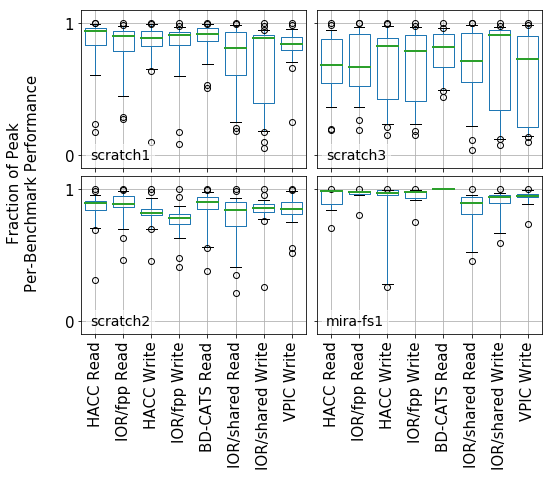

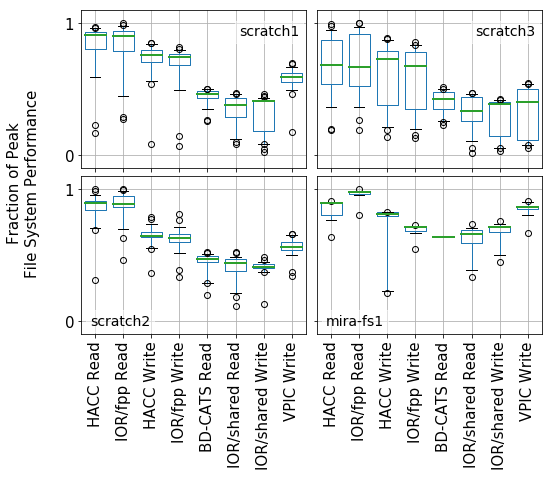

In [61]:
for plot_variable in performance_key, performance_key.replace('_by_', '_by_fs_'):
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
    fig.set_size_inches(8,6)
    boxplot_group_by = [ 'darshan_file_mode', 'darshan_rw', 'darshan_app' ]
    for idx, fs in enumerate(_FILE_SYSTEM_ORDER):
        icol = idx / 2
        irow = idx % 2
        ax = axes[irow, icol]
        df_concat.loc[df_concat["darshan_file_system"] == fs]\
        .boxplot(
            column=[plot_variable],
            by=boxplot_group_by,
            ax=axes[irow, icol],
            medianprops={'linewidth':2 },
            widths=0.75,
            whis=[5,95])

        settings = boxplot_settings[plot_variable]['title_pos'][irow]
        title = ax.set_title(fs, **(settings))
        title.set_bbox({'color': 'white', 'alpha': 0.5})
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.xaxis.grid(True)

        ### relabel the x axis labels
        new_labels = []
        for axis_label in ax.get_xticklabels():
            current_label = axis_label.get_text()
            axis_label.set_rotation(90)
            if "IOR" in current_label:
                if "shared" in current_label:
                    new_label = "IOR/shared"
                else:
                    new_label = "IOR/fpp"
            elif 'BD-CATS' in current_label:
                new_label = "BD-CATS"
            else:
                new_label = current_label.split(',')[2].strip(')').strip().split('-')[0]
            if 'write' in current_label:
                new_label += " Write"
            else:
                new_label += " Read"
            new_labels.append(new_label)

        ### set x tick labels for only the bottom row
        if irow == 0:
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels(new_labels,
                               fontsize=boxplot_settings['fontsize'])

        ax.yaxis.set_ticks([0.0, 1.0])
        ax.set_ylim([-0.1, 1.1])
        for ytick in ax.yaxis.get_major_ticks():
            ytick.label.set_fontsize(boxplot_settings['fontsize'])

        
    fig.suptitle("")
    # fig.text(0.5, -0.4, 'common X', ha='center')
    fig.text(0.0, 0.5,
             boxplot_settings[plot_variable]['ylabel'],
             verticalalignment='center',
             horizontalalignment='center',
             rotation='vertical',
             fontsize=boxplot_settings['fontsize'])
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    output_file = boxplot_settings[plot_variable]['output_file']
    fig.savefig(output_file, bbox_inches="tight")
    print "Saved %s" % output_file

Also plot a more general overview of performance across each file system.

Saved perf-boxplots-fs.pdf


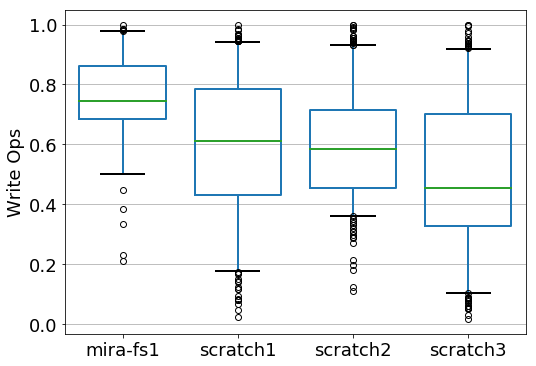

In [62]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
df_concat.boxplot(
    column=[plot_variable],
    by=["darshan_file_system"],
    ax=ax,
    widths=0.75,
    boxprops={'linewidth':2},
    medianprops={'linewidth':2 },
    whiskerprops={'linewidth':2},
    capprops={'linewidth':2},
    flierprops={'linewidth':2},
    whis=[5,95])
### add window dressing to plots
# plt.xticks(rotation=45)
fig.suptitle("")
ax.set_title("", fontsize=14 )
ax.set_xlabel("")
ax.set_ylabel(y_label)
ax.xaxis.grid(False)

output_file = "perf-boxplots-fs.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

Also create a boxplot of the coverage factor to demonstrate how often jobs were impacted by other jobs

Saved cf-boxplots-fs.pdf


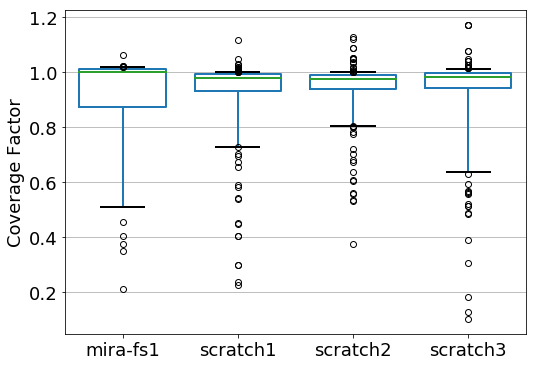

In [63]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
df_concat.boxplot(
    column=['coverage_factor'],
    by=["darshan_file_system"],
    ax=ax,
    widths=0.75,
    boxprops={'linewidth':2},
    medianprops={'linewidth':2 },
    whiskerprops={'linewidth':2},
    capprops={'linewidth':2},
    flierprops={'linewidth':2},
    whis=[5,95])
### add window dressing to plots
# plt.xticks(rotation=45)
fig.suptitle("")
ax.set_title("", fontsize=14 )
ax.set_xlabel("")
ax.set_ylabel("Coverage Factor")
ax.xaxis.grid(False)

output_file = "cf-boxplots-fs.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

Also try a coverage factor histogram since boxplots don't represent the long tail very well.

Saved cf-histogram-fs.pdf


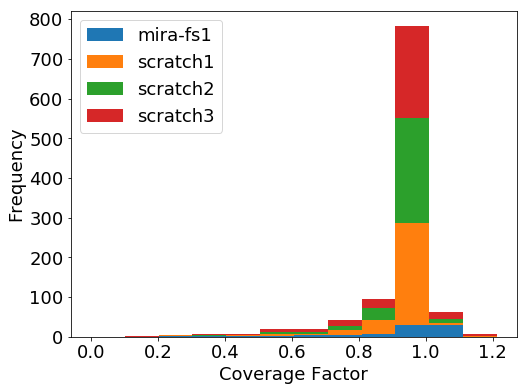

In [64]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

x = []
labels = []
for fs in df_concat['darshan_file_system'].unique():
    x.append(df_concat[df_concat["darshan_file_system"]==fs]["coverage_factor"].reset_index(drop=True).dropna())
    labels.append(fs) # in case the .unique() generator is nondeterministic
    
### retain the histogram results
histogram = ax.hist(x,
        bins=[0.101 * x for x in range(0,13)],
        label=labels,
        stacked=True
    )
# ax.yaxis.grid()
ax.legend()
ax.set_title("", fontsize=14 )
ax.set_xlabel("Coverage Factor")
ax.set_ylabel("Frequency")
fig.suptitle("")

output_file = "cf-histogram-fs.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

Calculate the cumulative distribution function (CDF) from the histogram data to get a probability distribution of observing a given coverage factor (CF).

In [65]:
for i in range(len(histogram[0])): # 4
    sums = [0 for x in range(len(histogram[0][i]))]
    for j in range(len(histogram[0][i])): # 13
        sums[j] += histogram[0][i][j]
probabilities = sums / sum(sums)
cumul = 0.0
print "%5s %6s %10s %10s" % ("CF", "Value", "CDF", "1-CDF")
for idx, probability in enumerate(probabilities):
    cumul += probability
    print "%5.3f %6.4f %10.4f %10.4f" % ( histogram[1][idx], probability, cumul, 1.0 - cumul )

   CF  Value        CDF      1-CDF
0.000 0.0000     0.0000     1.0000
0.101 0.0029     0.0029     0.9971
0.202 0.0048     0.0076     0.9924
0.303 0.0057     0.0133     0.9867
0.404 0.0067     0.0200     0.9800
0.505 0.0181     0.0381     0.9619
0.606 0.0190     0.0571     0.9429
0.707 0.0400     0.0971     0.9029
0.808 0.0914     0.1886     0.8114
0.909 0.7457     0.9343     0.0657
1.010 0.0600     0.9943     0.0057
1.111 0.0057     1.0000     0.0000


## Cumulative Distribution Functions

We now have a distribution for the coverage factor and performance.  What is the probability of getting anywhere near peak performance?  How does this vary with the coverage factor?

First calculate the cumulative distribution function for keys of interest:

In [66]:
def calculate_cdf( values ):
    """Create a pandas.Series that is the CDF of a list-like object"""

    denom = len(values) - 1
    x = sorted(values / values.max())
    y = [ i / denom for i in np.arange(len(x), dtype=np.float64) ]
    return pandas.Series( y, index=x )

In [67]:
### Calculate CDFs for (1) each file system and (2) performance and coverage factor
cdfs = {}
for fs in _FILE_SYSTEM_ORDER:
    df_fs = df_concat[df_concat['darshan_file_system'] == fs]
    for cdf_key in 'darshan_normalized_perf_by_max', 'coverage_factor':
        if cdf_key not in cdfs:
            cdfs[cdf_key] = {}
        cdf = calculate_cdf(df_fs[cdf_key])
        cdfs[cdf_key][fs] = {
            'dependent_variable':  cdf.index,
            'probability': cdf.values,
        }

In [68]:
### don't use counter_labels because the context is slightly different
cdf_labels = {
    'darshan_normalized_perf_by_max': "Fraction Peak Performance",
    'coverage_factor': "Coverage Factor",
}
cdf_file_labels = {
    'darshan_normalized_perf_by_max': "perf",
    'coverage_factor': "coverage-factor",
}

Saved cdf-both.pdf


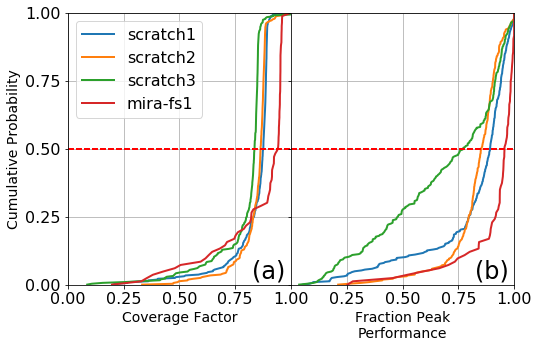

In [69]:
### Plot CDF side-by-side

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
fig.set_size_inches(8,5)

for fs in _FILE_SYSTEM_ORDER:
    for idx, cdf_key in enumerate(sorted(cdfs.keys())):
        axes[idx].plot(
                       cdfs[cdf_key][fs]['dependent_variable'],
                       cdfs[cdf_key][fs]['probability'],
                       label=fs,
                       linewidth=2)
        axes[idx].set_xlabel(wrap(cdf_labels[cdf_key]), fontsize=14)
        axes[idx].set_ylabel("")
        axes[idx].plot([0.0, 1.0],[0.5, 0.5], '--', linewidth=2.0, color='red')
        axes[idx].legend().remove()
        axes[idx].set_xticks([0.0, 0.25, 0.50, 0.75, 1.0])
        for tick in axes[idx].xaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
        for tick in axes[idx].yaxis.get_major_ticks():
            tick.label.set_fontsize(16)
axes[1].xaxis.get_major_ticks()[0].set_visible(False)
axes[0].set_title('(a)', position=(0.90,0.0), fontsize=24)
axes[1].set_title('(b)', position=(0.90,0.0), fontsize=24)
#fig.legend(
axes[0].legend(
    *(axes[0].get_legend_handles_labels()),
    fontsize=16
#   ncol=4,
#   mode="expand",
#   bbox_to_anchor=(0.11, 0.0, 0.79, 1.0),
#   loc="upper left",
#   borderaxespad=0.0
          )
axes[0].set_ylabel("Cumulative Probability", fontsize=14)
for i in 0, 1:
    axes[i].set_ylim([0.0, 1.0])
    axes[i].set_xlim([0.0, 1.0])
    axes[i].grid(True)
    axes[i].yaxis.set_ticks([0.0,0.25,0.50,0.75,1.0])
fig.suptitle("")
# fig.text(0.0, 0.5, "Cumulative Probability", va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.0, wspace=0.0)

output_file = "cdf-both.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file

## IOPS Coverage Factor

In [70]:
df = df_mira.copy()
df['iops_coverage_factor'] = (df_mira['darshan_total_rws'] / (df_mira['ggio_read_reqs'] + df_mira['ggio_write_reqs']))


When performance is high, iops coverage factor is high (so application has exclusive access to iops)
When performance is low, iops coverage factor is low



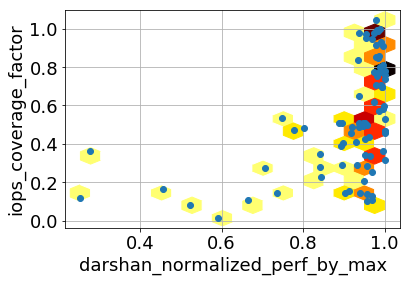

In [71]:
fig = plt.figure()
ax = fig.add_subplot('111')
x_counter = 'coverage_factor'
x_counter = 'darshan_normalized_perf_by_max'
y_counter = 'iops_coverage_factor'
ax.plot(df[x_counter],
        df[y_counter],
        marker='o',
        alpha=1.0,
        linewidth=0.0,
       )
result = ax.hexbin( df[x_counter],
            df[y_counter],
            gridsize=15,
            cmap='hot_r'
       )

ax.set_xlabel(x_counter)
ax.set_ylabel(y_counter)
ax.grid()
print """
When performance is high, iops coverage factor is high (so application has exclusive access to iops)
When performance is low, iops coverage factor is low
"""

Saved cdf-cf-bw-and-ops.pdf
Saved hist-cf-bw-and-ops.pdf


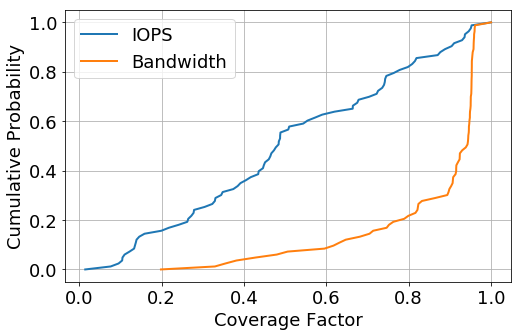

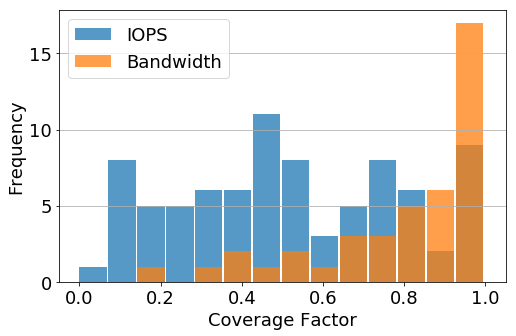

In [72]:
### CDF
fig = plt.figure()
fig.set_size_inches(8,5)
ax = fig.add_subplot("111")
ax.plot(calculate_cdf( df_mira['iops_coverage_factor'] ), label='IOPS', lw=2.0)
ax.plot(calculate_cdf( df_mira['coverage_factor'] ), label='Bandwidth', lw=2.0)
ax.set_xlabel("Coverage Factor")
ax.set_ylabel("Cumulative Probability")
ax.legend()
ax.grid()
output_file = "cdf-cf-bw-and-ops.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file


### Also try bar plots
fig = plt.figure()
fig.set_size_inches(8,5)
ax = fig.add_subplot("111")
y1 = df_mira['iops_coverage_factor']
y2 = df_mira['coverage_factor']
common_opts = {
                "width": 1.0/15.0,
                "bins": np.linspace(0.0, 1.0, 15),
                'alpha': 0.75,
                'lw': 3.0,
#                 'zorder': 9,
              }

# ax.hist( [ y1, y2 ], label=["IOPS", "Bandwidth"], **common_opts)
for y, label in [ 
                 (y1, 'IOPS'),
                 (y2, 'Bandwidth'),

                ]:
    ax.hist( y, label=label, **common_opts)

ax.set_xlabel("Coverage Factor")
ax.set_ylabel("Frequency")
ax.legend()
ax.yaxis.grid()
output_file = "hist-cf-bw-and-ops.pdf"
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file